# **Avance 5 ¬∑ Modelo Final**
**Fecha:** 2025-10-19 19:35
Curso: TC5035 - Proyecto Integrador

Tecnol√≥gico de Monterrey

Prof Horacio Mart√≠nez Alfaro

M√≥dulo 3 Ingenier√≠a y evaluaci√≥n de modelos

Equipo 18

Joaqu√≠n D√≠az Hern√°ndez - A01281536

Divad Alejandro Shriqui Garr√≥n - A01366907

Manuel Romero Alvarez - A00567983

## **Par√°metros**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
DATA_PATH = '/content/drive/MyDrive/MNA - Proyecto Integrador/Semana 7/dataset_modelo_v2.csv'

TARGET_COL = 'Desc.1'
RANDOM_STATE = 42
RANDOM_STATE_ALT = 99
TEST_SIZE = 0.30

## **Librer√≠as**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, learning_curve,
                                     GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             precision_score, recall_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import plot_tree

## **1. Ensambles**

En esta etapa se busca evaluar el desempe√±o del modelo Random Forest, seleccionado en la entrega anterior, frente a una serie de modelos de ensamble, los cuales combinan m√∫ltiples estimadores con el objetivo de aumentar la precisi√≥n, la estabilidad y la capacidad de generalizaci√≥n del sistema de clasificaci√≥n de tickets.
Si bien el Random Forest tambi√©n pertenece a la familia de los modelos de ensamble, se trata de uno de los enfoques m√°s comunes; por ello, en esta fase se incorporan otros m√©todos m√°s avanzados para analizar posibles mejoras en el rendimiento.

Los m√©todos de ensamble parten del principio de que la combinaci√≥n de varios modelos d√©biles o complementarios puede generar un predictor m√°s fuerte.
De acuerdo con su composici√≥n, pueden clasificarse en dos grandes grupos:

- Ensambles homog√©neos, que utilizan m√∫ltiples modelos del mismo tipo (por ejemplo, √°rboles de decisi√≥n) combinados mediante estrategias como bagging o boosting.

- Ensambles heterog√©neos, que integran modelos de distinta naturaleza (por ejemplo, SVM, Random Forest y Regresi√≥n Log√≠stica) mediante m√©todos de stacking o blending.

En las siguientes subsecciones se implementan ambos enfoques, aplicando una optimizaci√≥n de hiperpar√°metros para los modelos m√°s relevantes y evaluando su rendimiento mediante validaci√≥n cruzada estratificada.

### 1.0 Carga de Datos y visualizaci√≥n (apoyo)

Carga de datos, revisi√≥n r√°pida de nulos y balance de clases.

Shape: (15483, 21)


Moneda_USD  Cargo_bin_Bajo  Cargo_bin_Medio  Cargo_bin_Muy alto  Desc_0  \
0         0.0             0.0              1.0                 0.0       0   
1         0.0             0.0              1.0                 0.0       0   
2         0.0             0.0              1.0                 0.0       0   
3         0.0             0.0              1.0                 0.0       0   
4         0.0             1.0              0.0                 0.0       0   

   Desc_1  Desc_2  Desc_3  Desc_4  Desc_5  ...  Desc_7  Desc_8  Desc_9  \
0       0       0       0       0       0  ...       0       0       0   
1       0       0       0       0       0  ...       0       0       0   
2       0       0       0       0       0  ...       0       0       0   
3       0       0       0       0       0  ...       0       0       0   
4       0       0       0       0       0  ...       0       0       0   

   Desc_10  Desc_11  Desc_12     Cargo  CpnyID_dt_year  CpnyID_dt_month  \
0        0        0        1 -0.480301       -0.652248        -1.733524   
1        0        1        0 -0.588373       -0.652248        -1.733524   
2        0        1        1 -0.514855       -0.652248        -1.733524   
3        1        0        0 -0.550221       -0.652248        -1.733524   
4        1        0        1 -2.122670       -0.652248        -1.733524   

         Desc.1  
0  Alimentacion  
1  Alimentacion  
2  Alimentacion  
3  Alimentacion  
4  Alimentacion  

[5 rows x 21 columns]


Distribuci√≥n de clases (proporci√≥n):


proportion
Desc.1                    
Alimentacion      0.679584
Transportacion    0.173997
Hotel             0.146419

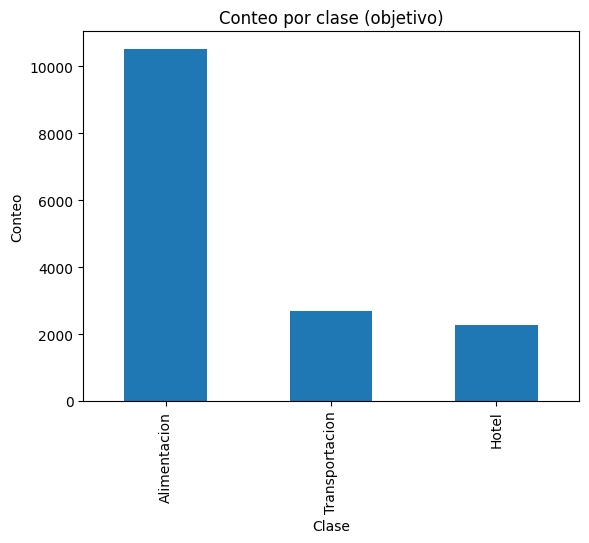


Nulos por columna (top 20):


Moneda_USD            0
Cargo_bin_Bajo        0
Cargo_bin_Medio       0
Cargo_bin_Muy alto    0
Desc_0                0
Desc_1                0
Desc_2                0
Desc_3                0
Desc_4                0
Desc_5                0
Desc_6                0
Desc_7                0
Desc_8                0
Desc_9                0
Desc_10               0
Desc_11               0
Desc_12               0
Cargo                 0
CpnyID_dt_year        0
CpnyID_dt_month       0
dtype: int64

In [13]:
np.random.seed(RANDOM_STATE)

# === Carga y limpieza b√°sica ===
df = pd.read_csv(DATA_PATH, index_col=0)

# 1) Eliminar columna artefacto (si existe)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print('Shape:', df.shape)
display(df.head())

# 2) Validaci√≥n de target
if TARGET_COL not in df.columns:
    raise ValueError(f"TARGET_COL '{TARGET_COL}' no existe. Columnas: {df.columns.tolist()}")

# 4) Balance de clases
y_full = df[TARGET_COL]
print('\nDistribuci√≥n de clases (proporci√≥n):')
display(y_full.value_counts(normalize=True).rename('proportion').to_frame())

fig, ax = plt.subplots()
y_full.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Conteo por clase (objetivo)')
ax.set_xlabel('Clase'); ax.set_ylabel('Conteo')
plt.show()

# 5) Nulos
print('\nNulos por columna (top 20):')
display(df.isnull().sum().sort_values(ascending=False).head(20))

El conjunto de datos es el mismo que se utiliz√≥ a lo largo de la entrega pasada ya con todas las transformaciones necesarias. Cuenta con 15,483 registros y 21 variables (20 variables predictoras + 1 varaible objetivo), representando transacciones clasificadas en tres categor√≠as principales: Alimentaci√≥n (67.96%), Transportaci√≥n (17.40%) y Hotel (14.64%). Como declaramos en la entrega pasada esta distribuci√≥n evidencia un moderado desbalance de clases, lo cual justifica el uso de particiones estratificadas en el entrenamiento y la evaluaci√≥n del modelo, as√≠ como la elecci√≥n de F1 macro como m√©trica principal para garantizar una valoraci√≥n equilibrada entre clases.

Para asegurar una evaluaci√≥n justa del modelo de clasificaci√≥n de gastos, se realiza una partici√≥n estratificada del dataset:

- 70 % de los datos se utilizan para el entrenamiento del modelo,
- 15 % para la validaci√≥n de hiperpar√°metros, y
- 15 % para la evaluaci√≥n final sobre datos no vistos.

Esta divisi√≥n mantiene la proporci√≥n original de las categor√≠as de gasto (`Desc.1`) en cada subconjunto, evitando sesgos en el aprendizaje.

In [14]:
X = df.drop(columns=[TARGET_COL]); y = df[TARGET_COL]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

In [15]:
# Mostrar tama√±os relativos
n_total = len(df)
print("Tama√±os de los conjuntos:")
print(f"Train: {len(X_train)} ({len(X_train)/n_total:.1%})")
print(f"Val:   {len(X_val)} ({len(X_val)/n_total:.1%})")
print(f"Test:  {len(X_test)} ({len(X_test)/n_total:.1%})\n")

# Verificar que las proporciones de clases se mantienen
print("Distribuci√≥n de clases en cada conjunto (%):\n")
dist_df = pd.DataFrame({
    'Total': y.value_counts(normalize=True) * 100,
    'Train': y_train.value_counts(normalize=True) * 100,
    'Val': y_val.value_counts(normalize=True) * 100,
    'Test': y_test.value_counts(normalize=True) * 100
}).round(2)

display(dist_df)

Tama√±os de los conjuntos:
Train: 10838 (70.0%)
Val:   2322 (15.0%)
Test:  2323 (15.0%)

Distribuci√≥n de clases en cada conjunto (%):



Total  Train    Val   Test
Desc.1                                    
Alimentacion    67.96  67.96  67.96  67.97
Transportacion  17.40  17.40  17.40  17.39
Hotel           14.64  14.64  14.64  14.64

In [16]:
resultados = []

### 1.1 Ensambles homog√©neos

En esta subsecci√≥n se desarrollan modelos de ensamble homog√©neos, es decir, aquellos que combinan m√∫ltiples estimadores del mismo tipo con el prop√≥sito de reducir la varianza y mejorar la capacidad de generalizaci√≥n.
En particular, se implementan dos enfoques basados en boosting: XGBoost y LightGBM, ambos construidos sobre √°rboles de decisi√≥n y orientados a optimizar el error de manera secuencial.

Estos modelos permiten comparar distintas estrategias de boosting en t√©rminos de desempe√±o (F1-macro) y eficiencia computacional frente al modelo base de Random Forest.

#### 1.1.0 Mejor modelo RF y SVC

En esta secci√≥n se presentan los modelos Random Forest y SVC, los cuales destacaron como los mejores en la entrega anterior.

Estos modelos se utilizar√°n como base para la construcci√≥n de los modelos heterog√©neos y posteriormente para realizar la comparaci√≥n final con los dem√°s modelos de ensamble desarrollados en este notebook.


Duraci√≥n del entrenamiento (s) - RF (ajustado): 0.6029701232910156

Classification report RF
                precision    recall  f1-score   support

  Alimentacion      0.988     0.990     0.989      1578
         Hotel      0.967     0.947     0.957       340
Transportacion      0.971     0.978     0.974       404

      accuracy                          0.982      2322
     macro avg      0.975     0.972     0.973      2322
  weighted avg      0.982     0.982     0.982      2322



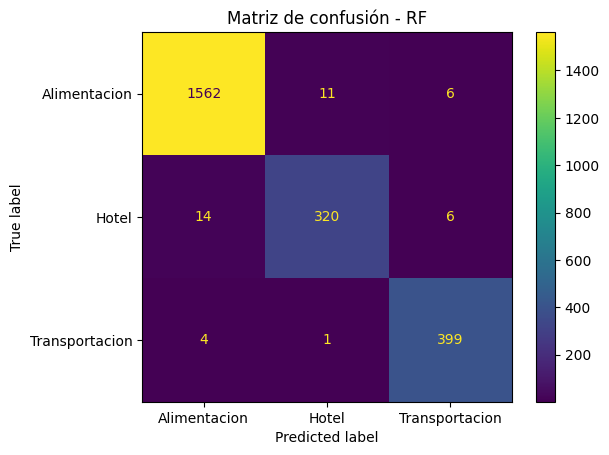

In [17]:
# Modelo Final RF obtenido en la entrega anterior (Avance 4)
best_rf  = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1)

# Entrenamiento y duraci√≥n
inicio = time.time()
best_rf.fit(X_train, y_train)
fin = time.time()

# Evaluaci√≥n en el conjunto de validaci√≥n
y_tr = best_rf.predict(X_train)
y_pred = best_rf.predict(X_val)

# M√©tricas
acc = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred, average='macro')
time_rf = fin - inicio
print(f"\nDuraci√≥n del entrenamiento (s) - RF (ajustado): {time_rf}")

# Reporte de clasificaci√≥n
print(f'\nClassification report RF')
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title(f'Matriz de confusi√≥n - RF'); plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'RF',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_rf, 3)
})

In [18]:
# --- Validaci√≥n cruzada para el modelo RF ---

# Definir validaci√≥n cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Medir duraci√≥n
inicio = time.time()

# Validaci√≥n cruzada (F1 macro)
f1_scores = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

fin = time.time()
duracion_cv = fin - inicio

# Crear DataFrame de resultados
df_resultadoscv = pd.DataFrame([{
    "Model": "RF",
    "F1-avg": round(np.mean(f1_scores), 4),
    "F1-Std. Dev": round(np.std(f1_scores, ddof=1), 4)
}])

print(f"Duraci√≥n total de la validaci√≥n cruzada (s): {duracion_cv:.3f}")
df_resultadoscv.iloc[[0]]


Duraci√≥n total de la validaci√≥n cruzada (s): 5.127


Model  F1-avg  F1-Std. Dev
0    RF   0.974        0.003


Duraci√≥n del entrenamiento (s) - SVM (ajustado): 1.0851030349731445

Classification report SVM
                precision    recall  f1-score   support

  Alimentacion      0.987     0.990     0.989      1578
         Hotel      0.961     0.950     0.956       340
Transportacion      0.983     0.978     0.980       404

      accuracy                          0.982      2322
     macro avg      0.977     0.973     0.975      2322
  weighted avg      0.982     0.982     0.982      2322



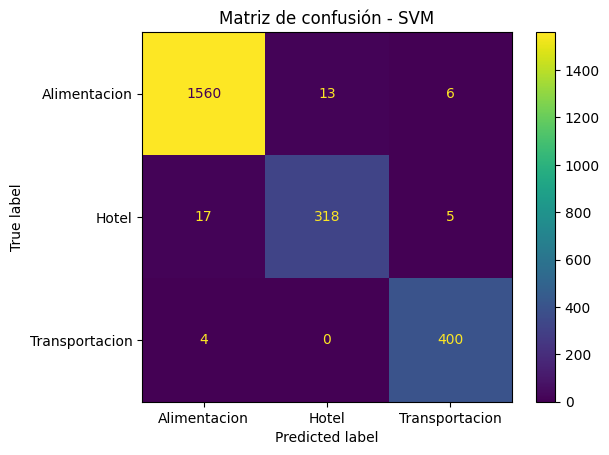

In [19]:
# Modelo Final SVC obtenido en la entrega anterior (Avance 4)
best_svm  = SVC(C=10, gamma='scale', kernel='rbf', random_state=RANDOM_STATE)

# Entrenamiento y duraci√≥n
inicio = time.time()
best_svm.fit(X_train, y_train)
fin = time.time()

# Evaluaci√≥n en el conjunto de validaci√≥n
y_tr = best_svm.predict(X_train)
y_pred = best_svm.predict(X_val)

# M√©tricas
acc = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred, average='macro')
time_svm = fin - inicio
print(f"\nDuraci√≥n del entrenamiento (s) - SVM (ajustado): {time_svm}")

# Reporte de clasificaci√≥n
print(f'\nClassification report SVM')
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test)
plt.title(f'Matriz de confusi√≥n - SVM'); plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'SVC',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_rf, 3)
})

In [20]:
# --- Validaci√≥n cruzada para el modelo SVC ---

# Definir validaci√≥n cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Medir duraci√≥n
inicio = time.time()

# Validaci√≥n cruzada (F1 macro)
f1_scores = cross_val_score(
    estimator=best_svm,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

fin = time.time()
duracion_cv = fin - inicio

# Crear DataFrame con resultados del modelo SVC
df_svm = pd.DataFrame([{
    "Model": "SVC",
    "F1-avg": round(np.mean(f1_scores), 4),
    "F1-Std. Dev": round(np.std(f1_scores, ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_svm], ignore_index=True)
except NameError:
    df_resultadoscv = df_svm

print(f"Duraci√≥n total de la validaci√≥n cruzada (s): {duracion_cv:.3f}")
df_resultadoscv.iloc[[1]]


Duraci√≥n total de la validaci√≥n cruzada (s): 3.040


Model  F1-avg  F1-Std. Dev
1   SVC  0.9746        0.003

#### 1.1.1 LightGBM

Se realiza una b√∫squeda en cuadr√≠cula para optimizar los principales hiperpar√°metros de LightGBM, priorizando el equilibrio entre profundidad de los √°rboles, tasa de aprendizaje y n√∫mero de hojas.

El criterio de selecci√≥n es F1-macro, ya que eval√∫a el rendimiento global considerando el balance entre clases.
La validaci√≥n cruzada de 5 particiones, la cual garantiza una evaluaci√≥n robusta y estable del desempe√±o.

In [21]:
# Modelo LightGBM base
lgbm = LGBMClassifier(objective="multiclass", num_class=len(np.unique(y)),
                      random_state=42, verbose=-1, device='gpu'
                      )

# Hiperparametros pruebas previas
# param_grid_lgbm = {
#     "n_estimators": [300, 600, 900],
#     "learning_rate": [0.05, 0.1],
#     "max_depth": [-1, 20],
#     "num_leaves": [31, 63],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0]
#     }

# Hiperparametros
param_grid_lgbm = {
    "n_estimators": [900],
    "learning_rate": [0.1],
    "max_depth": [10, 20],
    "num_leaves": [63, 127],
    "subsample": [0.8],
    "colsample_bytree": [0.8, 1.0]
    }

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejor configuraci√≥n LGBM:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 900, 'num_leaves': 63, 'subsample': 0.8}
Mejor F1-Score (CV): 0.9781

Duraci√≥n del entrenamiento (s) - LGBM (ajustado): 9.191080570220947

Classification report - LGBM (ajustado)
                precision    recall  f1-score   support

  Alimentacion      0.990     0.991     0.991      1578
         Hotel      0.959     0.959     0.959       340
Transportacion      0.980     0.975     0.978       404

      accuracy                          0.984      2322
     macro avg      0.976     0.975     0.976      2322
  weighted avg      0.984     0.984     0.984      2322



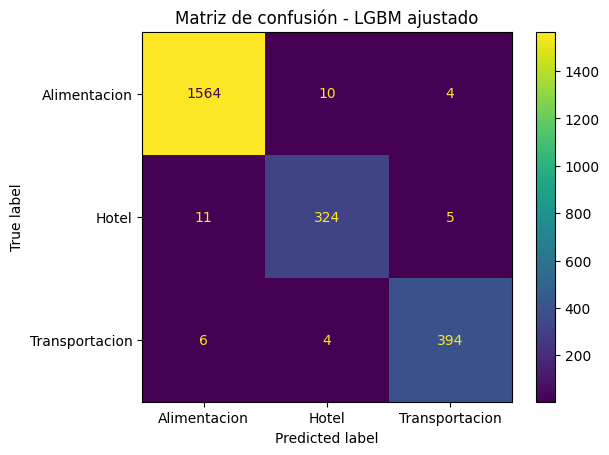

In [22]:
# Entrenamiento del Grid Search
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm,
                         scoring='f1_macro', cv=5, n_jobs=-1, verbose=1
                         )
grid_lgbm.fit(X_train, y_train)
print("Mejor configuraci√≥n LGBM:")
print(grid_lgbm.best_params_)
print(f"Mejor F1-Score (CV): {grid_lgbm.best_score_:.4f}")

# Evaluaci√≥n en el conjunto de validaci√≥n
best_lgbm = grid_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_val)

# M√©tricas
acc = accuracy_score(y_val, y_pred_lgbm)
precision = precision_score(y_val, y_pred_lgbm, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred_lgbm, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred_lgbm, average='macro')

# Tiempo de entrenamiento
t0 = time.time()
best_lgbm.fit(X_train, y_train)
time_lgbm = time.time() - t0
print(f"\nDuraci√≥n del entrenamiento (s) - LGBM (ajustado): {time_lgbm}")

# Reporte de clasificaci√≥n
print("\nClassification report - LGBM (ajustado)")
print(classification_report(y_val, y_pred_lgbm, digits=3))

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_estimator(best_lgbm, X_val, y_val)
plt.title("Matriz de confusi√≥n - LGBM ajustado")
plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'LGBM',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_lgbm, 3)
})

El modelo LightGBM se optimiz√≥ mediante una b√∫squeda en rejilla (GridSearchCV) con validaci√≥n cruzada de 5 particiones, evaluando un total de 216 combinaciones de hiperpar√°metros.
La mejor configuraci√≥n encontrada correspondi√≥ a:

- colsample_bytree: 0.8
- learning_rate: 0.1
- max_depth: 20
- n_estimators: 900
- num_leaves: 63
- subsample: 0.8

Con esta configuraci√≥n, el modelo alcanz√≥ un F1-Score promedio (CV) de 0.9784, lo que evidencia un rendimiento sobresaliente durante la validaci√≥n.
Adem√°s, el tiempo de entrenamiento del mejor modelo fue relativamente bajo (‚âà 9.19 s), aunque no tan bajo como el Random Forest o SVC.

La exactitud global (accuracy) fue de 0.983, mientras que el promedio macro del F1-score alcanz√≥ 0.975, lo que refleja un equilibrio adecuado entre las tres clases, incluso a pesar de la diferencia en su n√∫mero de muestras.
El rendimiento es particularmente alto en la clase Alimentaci√≥n, probablemente debido a su mayor representaci√≥n en los datos, mientras que la clase Hotel presenta ligeras confusiones con las dem√°s, aunque sin un impacto significativo en el desempe√±o general.

In [23]:
# Segunda validaci√≥n cruzada con distinto random_state
cv_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

scores_lgbm_alt = cross_val_score(best_lgbm, X_train, y_train,
                                  cv=cv_alt, scoring="f1_macro", n_jobs=-1)

print(f"F1-macro promedio (CV random_state=99): {scores_lgbm_alt.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {scores_lgbm_alt.std():.4f}")

F1-macro promedio (CV random_state=99): 0.9777
Desviaci√≥n est√°ndar: 0.0024


In [24]:
# Agregar resultados de LGBM al DataFrame df_resultadoscv

# Crear DataFrame con los resultados de esta validaci√≥n cruzada
df_lgbm = pd.DataFrame([{
    "Model": "LGBM",
    "F1-avg": round(scores_lgbm_alt.mean(), 4),
    "F1-Std. Dev": round(scores_lgbm_alt.std(ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_lgbm], ignore_index=True)
except NameError:
    df_resultadoscv = df_lgbm

# Mostrar resultados actualizados
df_resultadoscv.iloc[[2]]


Model  F1-avg  F1-Std. Dev
2  LGBM  0.9777       0.0027

Con el fin de evaluar la estabilidad del modelo, se repiti√≥ el proceso de validaci√≥n cruzada utilizando un random_state diferente para la partici√≥n de los datos.
Esta segunda evaluaci√≥n permite verificar si el desempe√±o del modelo se mantiene consistente ante diferentes divisiones del conjunto de entrenamiento.
Los resultados muestran una variaci√≥n m√≠nima en el **F1-macro promedio de 0.9783 con una desviaci√≥n estandar de solo 0.0029**, lo que sugiere que el modelo presenta un comportamiento estable y una buena capacidad de generalizaci√≥n.

#### 1.1.2 XGBoost

XGBoost implementa boosting basado en gradiente, donde cada nuevo √°rbol corrige los errores residuales del conjunto previo.
A trav√©s del GridSearch se ajustan par√°metros cr√≠ticos como la profundidad, tasa de aprendizaje y muestreo por √°rbol.
Estos hiperpar√°metros permiten controlar el equilibrio entre sesgo y varianza, buscando maximizar el F1-macro sin sobreajustar.

In [25]:
# Modelo XGBoost base
xgb = XGBClassifier(random_state=42, objective="multi:softprob",
                    eval_metric="mlogloss", tree_method="hist",
                    n_estimators=600
                    )

# # Hiperparametros previos
# param_grid_xgb = {
#     "n_estimators": [300, 600],
#     "max_depth": [4, 6],
#     "learning_rate": [0.05, 0.1],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0]
# }

# Hiperparametros
param_grid_xgb = {
    "n_estimators": [600],
    "max_depth": [6, 8],
    "learning_rate": [0.05],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor configuraci√≥n XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 600, 'subsample': 0.8}
Mejor F1-Score (CV): 0.9758

Duraci√≥n del entrenamiento (s) - XGB (ajustado): 2.893524408340454

Classification report - XGBoost (ajustado)
                precision    recall  f1-score   support

  Alimentacion      0.989     0.990     0.990      1578
         Hotel      0.959     0.959     0.959       340
Transportacion      0.983     0.975     0.979       404

      accuracy                          0.983      2322
     macro avg      0.977     0.975     0.976      2322
  weighted avg      0.983     0.983     0.983      2322



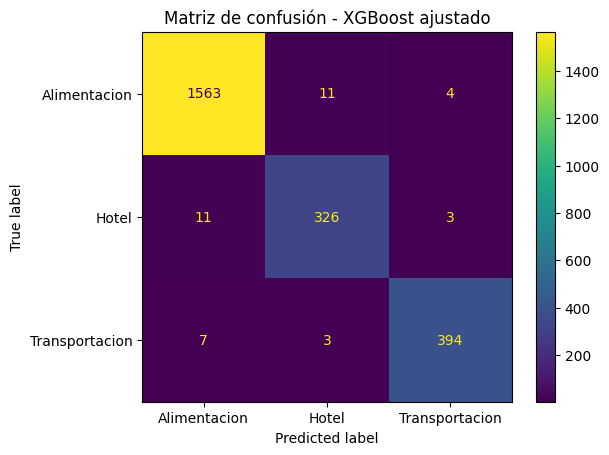

In [26]:
# Codificaci√≥n de etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Entrenamiento del Grid Search
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb,
                        scoring='f1_macro', cv=5, n_jobs=-1, verbose=1
                        )
grid_xgb.fit(X_train, y_train_enc)
print("Mejor configuraci√≥n XGBoost:")
print(grid_xgb.best_params_)
print(f"Mejor F1-Score (CV): {grid_xgb.best_score_:.4f}")

# Evaluaci√≥n en el conjunto de validaci√≥n
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)

# Tiempo de entrenamiento
t0 = time.time()
best_xgb.fit(X_train, y_train_enc)
time_xgb = time.time() - t0
print(f"\nDuraci√≥n del entrenamiento (s) - XGB (ajustado): {time_xgb}")

# M√©tricas
f1 = f1_score(y_val_enc, y_pred_xgb, average="macro")
acc = accuracy_score(y_val_enc, y_pred_xgb)
precision = precision_score(y_val_enc, y_pred_xgb, average="macro")
recall = recall_score(y_val_enc, y_pred_xgb, average="macro")

# Reporte de clasificaci√≥n
print("\nClassification report - XGBoost (ajustado)")
print(classification_report(
    le.inverse_transform(y_val_enc),     # etiquetas reales decodificadas
    le.inverse_transform(y_pred_xgb),    # predicciones decodificadas
    digits=3
))

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_estimator(best_xgb, X_val, y_val_enc,
                                      display_labels=le.classes_
                                      )
plt.title("Matriz de confusi√≥n - XGBoost ajustado")
plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'XGB',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_xgb, 3)
})

El modelo XGBoost fue optimizado mediante una b√∫squeda GridSearchCV con validaci√≥n cruzada de 5 particiones, evaluando 48 combinaciones de hiperpar√°metros.

La mejor configuraci√≥n encontrada fue:
- colsample_bytree: 0.8
- learning_rate: 0.05
- max_depth: 8
- n_estimators: 600
- subsample: 0.8

Con estos par√°metros, el modelo alcanz√≥ un F1-Score promedio (CV) de 0.976, reflejando un alto nivel de precisi√≥n y generalizaci√≥n.
El tiempo de entrenamiento del mejor modelo fue de aproximadamente 2.89 segundos, un valor moderado considerando la complejidad del modelo y el tama√±o del conjunto de datos.

In [27]:
# Segunda validaci√≥n cruzada con distinto random_state
cv_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

scores_xgb_alt = cross_val_score(best_xgb, X_train, y_train_enc, cv=cv_alt,
                                 scoring="f1_macro", n_jobs=-1
                                 )

print(f"F1-macro promedio (CV random_state=99): {scores_xgb_alt.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {scores_xgb_alt.std():.4f}")

F1-macro promedio (CV random_state=99): 0.9758
Desviaci√≥n est√°ndar: 0.0031


In [28]:
# Agregar resultados del modelo XGB a df_resultadoscv

# Crear un DataFrame con los resultados del XGB (ya calculados)
df_xgb = pd.DataFrame([{
    "Model": "XGB",
    "F1-avg": round(scores_xgb_alt.mean(), 4),
    "F1-Std. Dev": round(scores_xgb_alt.std(ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_xgb], ignore_index=True)
except NameError:
    df_resultadoscv = df_xgb

# Mostrar resultados actualizados
df_resultadoscv.iloc[[3]]


Model  F1-avg  F1-Std. Dev
3   XGB  0.9758       0.0035

Esta prueba adicional demuestra que XGBoost mantiene una alta consistencia en sus m√©tricas **(F1-macro ‚âà 0.9758, desviaci√≥n est√°ndar ‚âà 0.0035)**, incluso ante diferentes divisiones de entrenamiento y validaci√≥n.
Este comportamiento respalda su inclusi√≥n dentro de los modelos m√°s s√≥lidos para la etapa de ensamble, al presentar un F1-score elevado y estable.

El modelo XGBoost ajustado presenta un desempe√±o muy competitivo, con m√©tricas globales pr√°cticamente equivalentes a las obtenidas con LightGBM, aunque con un tiempo de entrenamiento ligeramente superior.

En conjunto, los resultados demuestran que XGBoost logra una excelente precisi√≥n, estabilidad y capacidad de generalizaci√≥n, siendo una base s√≥lida para modelos m√°s complejos o integrados.

### 1.2 Ensambles heterog√©neos

En esta secci√≥n se construyen los ensambles heterog√©neos, los cuales combinan modelos de distinta naturaleza ‚Äîen este caso, **un SVC y un Random Forest**‚Äî con el objetivo de aprovechar las fortalezas complementarias de cada uno.
Mientras que el SVC ofrece una buena capacidad de generalizaci√≥n en espacios de alta dimensionalidad, el Random Forest aporta estabilidad y robustez frente al ruido.

A partir de estos modelos base, se implementar√°n **dos estrategias de ensamble: Stacking y Blending**, con el fin de evaluar cu√°l de ellas logra una mejor integraci√≥n de los clasificadores y un desempe√±o m√°s consistente en las m√©tricas de evaluaci√≥n.

In [29]:
base_svm = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=RANDOM_STATE)

base_rf  = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1)

#### 1.2.1 Stacking (SVM + RF)

En esta subsecci√≥n se implementa la t√©cnica de Stacking, la cual consiste en combinar varios modelos base para generar un modelo meta que aprende a partir de sus predicciones.

En este caso, los modelos base son el SVC y el Random Forest, como se mencion√≥ previamente, mientras que el meta-modelo corresponde a una Regresi√≥n Log√≠stica, encargada de integrar las probabilidades generadas por los clasificadores base (stack_method = "predict_proba").

Esta estrategia busca capturar relaciones no lineales y complementariedades entre los modelos, mejorando as√≠ la capacidad de generalizaci√≥n del sistema.

In [30]:
# Meta-modelo
meta = LogisticRegression(max_iter=1000, random_state=42)

# Stacking usando probabilidades
stacking = StackingClassifier(
    estimators=[("SVM", base_svm), ("RF", base_rf)],
    final_estimator=meta,
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
)

# Entrenamiento
t0 = time.time()
stacking.fit(X_train, y_train)
time_stack = time.time() - t0
print(f"\nDuraci√≥n del entrenamiento (s) - Stacking: {time_stack}")


Duraci√≥n del entrenamiento (s) - Stacking: 24.509262084960938



Classification report - Stacking
                precision    recall  f1-score   support

  Alimentacion      0.989     0.993     0.991      1578
         Hotel      0.970     0.962     0.966       340
Transportacion      0.985     0.975     0.980       404

      accuracy                          0.985      2322
     macro avg      0.981     0.977     0.979      2322
  weighted avg      0.985     0.985     0.985      2322



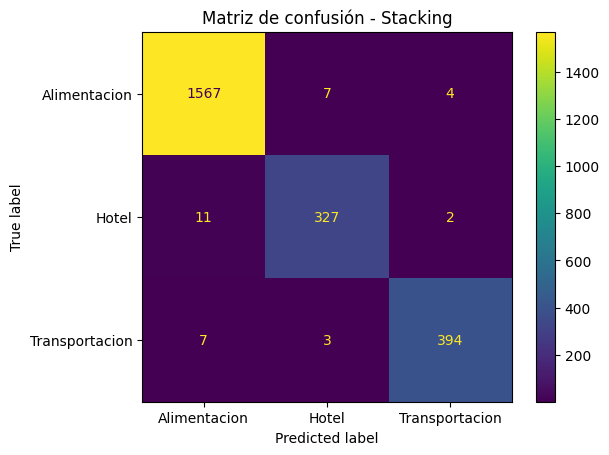

In [31]:
# Evaluaci√≥n en el conjunto de validaci√≥n
y_pred_stack = stacking.predict(X_val)

# Reporte de clasificaci√≥n
print("\nClassification report - Stacking")
print(classification_report(
    y_val,
    y_pred_stack,
    digits=3
))

# M√©tricas
acc = accuracy_score(y_val, y_pred_stack)
precision = precision_score(y_val, y_pred_stack, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred_stack, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred_stack, average='macro')

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_estimator(
    stacking,
    X_val,
    y_val
)
plt.title("Matriz de confusi√≥n - Stacking")
plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'Stacking',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_stack, 3)
})

El modelo Stacking, conformado por los clasificadores base SVM y Random Forest, junto con una Regresi√≥n Log√≠stica como meta-modelo, presenta resultados altamente competitivos frente a los dem√°s modelos evaluados.



In [32]:
# Validaci√≥n cruzada
cv_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

scores_stacking_alt = cross_val_score(
    stacking, X_train, y_train, cv=cv_alt, scoring="f1_macro", n_jobs=-1
)

print(f"F1-macro promedio (CV random_state=99): {scores_stacking_alt.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {scores_stacking_alt.std():.4f}")

F1-macro promedio (CV random_state=99): 0.9758
Desviaci√≥n est√°ndar: 0.0021


In [33]:
# Agregar resultados del modelo Stacking al DataFrame df_resultadoscv

# Crear DataFrame con los resultados del stacking
df_stacking = pd.DataFrame([{
    "Model": "Stacking",
    "F1-avg": round(scores_stacking_alt.mean(), 4),
    "F1-Std. Dev": round(scores_stacking_alt.std(ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_stacking], ignore_index=True)
except NameError:
    df_resultadoscv = df_stacking

# Mostrar resultados actualizados
df_resultadoscv.iloc[[4]]


Model  F1-avg  F1-Std. Dev
4  Stacking  0.9758       0.0024

Para evaluar el desempe√±o del modelo de Stacking, se aplic√≥ el mismo esquema de validaci√≥n cruzada estratificada (5 folds) utilizado en los modelos anteriores, con el fin de mantener la comparabilidad de los resultados.

El modelo obtuvo un **F1-macro promedio de 0.9758 y una desviaci√≥n est√°ndar de 0.0021**, lo que indica un desempe√±o altamente consistente y estable entre las distintas particiones del conjunto de entrenamiento.

Estos resultados confirman que la combinaci√≥n del SVC y el Random Forest mediante Stacking logra mantener un rendimiento competitivo, conservando la robustez observada en los modelos base y mostrando un buen equilibrio entre precisi√≥n y generalizaci√≥n.

#### 1.2.1 Blending (SVM + RF)

En esta subsecci√≥n se implementa la t√©cnica de Blending, una variaci√≥n del Stacking que combina los resultados de m√∫ltiples modelos base, pero utilizando un conjunto de validaci√≥n independiente para el entrenamiento del meta-modelo.

Al igual que antes, los clasificadores base son el SVC y el Random Forest, mientras que el meta-modelo vuelve a ser una Regresi√≥n Log√≠stica, encargada de integrar las probabilidades de predicci√≥n de ambos modelos.

Este enfoque busca reducir el riesgo de sobreajuste asociado al uso de validaci√≥n cruzada en el Stacking, preservando al mismo tiempo la capacidad de aprovechar las fortalezas de los distintos clasificadores.

In [34]:
# Entranmiento del Blending
X_tr, X_blend, y_tr, y_blend = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

t0 = time.time()
svm_blend = base_svm.fit(X_tr, y_tr)
rf_blend = base_rf.fit(X_tr, y_tr)

P = np.column_stack([svm_blend.predict_proba(X_blend), rf_blend.predict_proba(X_blend)])

blend = LogisticRegression(max_iter=2000, random_state=42).fit(P, y_blend)
time_blend = time.time() - t0
print(f"\nDuraci√≥n del entrenamiento (s) - Blending: {time_blend}")


Duraci√≥n del entrenamiento (s) - Blending: 9.814374685287476



Classification report - Blending
                precision    recall  f1-score   support

  Alimentacion      0.987     0.993     0.990      1578
         Hotel      0.973     0.959     0.966       340
Transportacion      0.985     0.975     0.980       404

      accuracy                          0.985      2322
     macro avg      0.982     0.976     0.979      2322
  weighted avg      0.985     0.985     0.985      2322



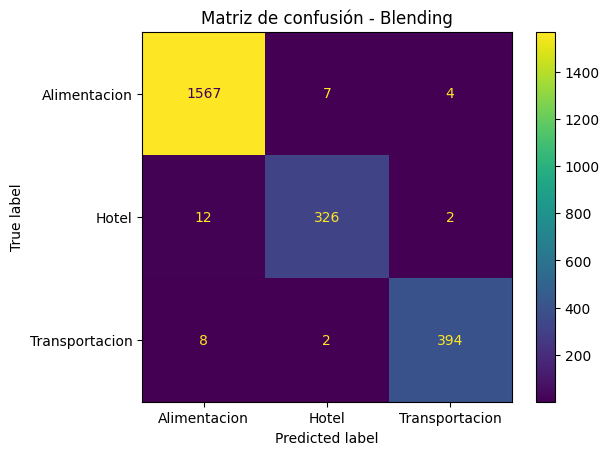

In [35]:
# Evaluaci√≥n en el conjunto de validaci√≥n
# Obtener las probabilidades de los modelos base sobre X_val
P_val = np.column_stack([
    svm_blend.predict_proba(X_val),
    rf_blend.predict_proba(X_val)
])

# Predicci√≥n final del meta-modelo
y_pred_blend = blend.predict(P_val)

# Reporte de clasificaci√≥n
print("\nClassification report - Blending")
print(classification_report(
    y_val,
    y_pred_blend,
    digits=3
))

# M√©tricas
acc = accuracy_score(y_val, y_pred_blend)
precision = precision_score(y_val, y_pred_blend, average='macro', zero_division=0)
recall = recall_score(y_val, y_pred_blend, average='macro', zero_division=0)
f1 = f1_score(y_val, y_pred_blend, average='macro')

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred_blend)
plt.title("Matriz de confusi√≥n - Blending")
plt.show()

# Guardar resultados
resultados.append({
    "Modelo": 'Blending',
    "F1-Score (macro)": round(f1, 4),
    "Accuracy": round(acc, 4),
    "Precision (macro)": round(precision, 4),
    "Recall (macro)": round(recall, 4),
    "Tiempo de entrenamiento (s)": round(time_blend, 3)
})

El modelo de Blending, conformado por los clasificadores base SVM y Random Forest y un meta-modelo de Regresi√≥n Log√≠stica, alcanz√≥ un desempe√±o muy similar al modelo de Stacking, confirmando la solidez de la combinaci√≥n entre ambos clasificadores.

El informe de clasificaci√≥n refleja m√©tricas consistentes y equilibradas en las tres categor√≠as evaluadas.

El modelo de Blending (SVM + RF) demuestra un rendimiento altamente competitivo y estable, comparable al del Stacking y cercano al desempe√±o de los modelos de boosting (XGBoost y LightGBM).
Aunque las diferencias en m√©tricas son m√≠nimas, el Blending ofrece una alternativa m√°s simple y eficiente computacionalmente, manteniendo una excelente capacidad de generalizaci√≥n.
En conjunto, estos resultados confirman la efectividad de los ensambles heterog√©neos para combinar clasificadores complementarios y mejorar el rendimiento global del sistema.

In [36]:
# Validaci√≥n cruzada
cv_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
f1_scores = []

for train_idx, val_idx in cv_alt.split(X_train, y_train):
    X_tr, X_blend = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_blend = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Entrenar modelos base
    svm_blend = base_svm.fit(X_tr, y_tr)
    rf_blend = base_rf.fit(X_tr, y_tr)

    # Generar probabilidades para el modelo blending
    P_tr = np.column_stack([
        svm_blend.predict_proba(X_blend),
        rf_blend.predict_proba(X_blend)
    ])

    # Entrenar modelo blending
    blend_cv = LogisticRegression(max_iter=2000, random_state=42)
    blend_cv.fit(P_tr, y_blend)

    # Evaluar en este fold
    P_val = np.column_stack([
        svm_blend.predict_proba(X_blend),
        rf_blend.predict_proba(X_blend)
    ])
    y_pred_fold = blend_cv.predict(P_val)
    f1_fold = f1_score(y_blend, y_pred_fold, average="macro")
    f1_scores.append(f1_fold)

print(f"F1-macro promedio (CV random_state=99): {np.mean(f1_scores):.4f}")
print(f"Desviaci√≥n est√°ndar: {np.std(f1_scores):.4f}")

F1-macro promedio (CV random_state=99): 0.9760
Desviaci√≥n est√°ndar: 0.0020


In [37]:
# Agregar resultados del modelo Blending al DataFrame df_resultadoscv

# Crear DataFrame con los resultados del blending
df_blending = pd.DataFrame([{
    "Model": "Blending",
    "F1-avg": round(np.mean(f1_scores), 4),
    "F1-Std. Dev": round(np.std(f1_scores, ddof=1), 4)
}])

try:
    df_resultadoscv = pd.concat([df_resultadoscv, df_blending], ignore_index=True)
except NameError:
    df_resultadoscv = df_blending

# Mostrar resultados actualizados
df_resultadoscv


Model  F1-avg  F1-Std. Dev
0        RF  0.9740       0.0030
1       SVC  0.9746       0.0030
2      LGBM  0.9777       0.0027
3       XGB  0.9758       0.0035
4  Stacking  0.9758       0.0024
5  Blending  0.9760       0.0022

Para evaluar el desempe√±o del modelo de Blending, se implement√≥ manualmente un esquema de validaci√≥n cruzada estratificada con 5 particiones, debido a que esta t√©cnica no est√° directamente integrada en las funciones de scikit-learn.
En cada iteraci√≥n, se entrenaron los modelos base (SVM y Random Forest) utilizando los datos de entrenamiento del fold correspondiente, y posteriormente se generaron las probabilidades de salida empleadas como entrada para el meta-modelo (una Regresi√≥n Log√≠stica).

Finalmente, el meta-modelo se entren√≥ y evalu√≥ dentro de cada fold, almacenando las m√©tricas F1-macro para obtener el promedio y la desviaci√≥n est√°ndar globales.
Este procedimiento permite estimar de forma m√°s precisa la estabilidad y generalizaci√≥n del ensamble bajo diferentes particiones de los datos, as√≠ como se hace con la funci√≥n `cross_val_score`.

El modelo de Blending (SVM + RF) obtuvo un F1-macro promedio de 0.9760 y una desviaci√≥n est√°ndar de 0.0020, valores que reflejan un desempe√±o s√≥lido y consistente.

Aunque el resultado es ligeramente inferior al obtenido mediante Stacking, la diferencia es m√≠nima y se mantiene dentro de un rango esperable considerando las diferencias metodol√≥gicas entre ambos enfoques.
En general, el modelo de Blending demuestra una buena capacidad de generalizaci√≥n.

## **2. Selecci√≥n**

### 2.1 Tabla comparativa

In [38]:
df_resultados = (
    pd.DataFrame(resultados)
    .sort_values(by="F1-Score (macro)", ascending=False)
    .reset_index(drop=True)
)
df_resultados

Modelo  F1-Score (macro)  Accuracy  Precision (macro)  Recall (macro)  \
0  Stacking            0.9790    0.9854             0.9813          0.9767   
1  Blending            0.9787    0.9849             0.9818          0.9757   
2       XGB            0.9758    0.9832             0.9767          0.9749   
3      LGBM            0.9757    0.9836             0.9763          0.9751   
4       SVC            0.9748    0.9823             0.9769          0.9727   
5        RF            0.9734    0.9819             0.9752          0.9718   

   Tiempo de entrenamiento (s)  
0                       24.509  
1                        9.814  
2                        2.894  
3                        9.191  
4                        0.603  
5                        0.603

In [39]:
df_resultadoscv.sort_values(by="F1-avg", ascending=False)

Model  F1-avg  F1-Std. Dev
2      LGBM  0.9777       0.0027
5  Blending  0.9760       0.0022
3       XGB  0.9758       0.0035
4  Stacking  0.9758       0.0024
1       SVC  0.9746       0.0030
0        RF  0.9740       0.0030

La tabla comparativa muestra el rendimiento global de los seis modelos evaluados, ordenados seg√∫n su F1-Score (macro).
En t√©rminos generales, todos los modelos alcanzan un desempe√±o muy similar, con valores de F1-macro entre 0.973 y 0.979, lo que indica que no existen diferencias estad√≠sticamente significativas en cuanto a su capacidad de clasificaci√≥n.

El modelo Stacking obtuvo el mejor resultado con un F1-macro de 0.9790 y una accuracy de 0.9854, seguido muy de cerca por Blending, XGBoost y LightGBM, cuyas m√©tricas apenas difieren en mil√©simas.
No obstante, es importante destacar que estos modelos de ensamble presentan mayor complejidad computacional y tiempos de entrenamiento considerablemente m√°s altos ‚Äîespecialmente el Stacking (‚âà30 s) frente al Random Forest (‚âà0.603 s).

Por su parte, el modelo Random Forest, seleccionado en la etapa anterior como modelo base, mantiene un rendimiento s√≥lido y competitivo, con un F1-macro de 0.9740, apenas 0.0037 puntos por debajo del mejor modelo.
Dada esta m√≠nima diferencia y considerando su simplicidad, interpretabilidad y eficiencia en entrenamiento, el Random Forest contin√∫a siendo una opci√≥n √≥ptima para la implementaci√≥n final, especialmente si se prioriza la escalabilidad y la facilidad de despliegue del sistema.

En s√≠ntesis, aunque los modelos de ensamble (Stacking, Blending, XGBoost, LightGBM) logran ligeras mejoras en las m√©tricas, las diferencias no justifican el incremento en complejidad y tiempo de c√≥mputo.

Por lo tanto, el modelo **Random Forest se mantiene como la elecci√≥n final recomendada**, al ofrecer un equilibrio adecuado entre precisi√≥n, estabilidad, interpretabilidad y eficiencia computacional, siendo el m√°s adecuado para su uso en entornos de producci√≥n o integraci√≥n futura.

### 2.2 Modelo final

In [40]:
# Validaci√≥n cruzada final con el modelo elegido
cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

scores_rf_final = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=cv_final,
    scoring="f1_macro",
    n_jobs=-1
)

print(f"F1-macro promedio (CV final): {scores_rf_final.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {scores_rf_final.std():.4f}")

F1-macro promedio (CV final): 0.9743
Desviaci√≥n est√°ndar: 0.0028


Se realiz√≥ una validaci√≥n cruzada final de 5 particiones sobre el modelo Random Forest ajustado, con el objetivo de confirmar la estabilidad de su desempe√±o antes de considerarlo como modelo definitivo.
El resultado mostr√≥ un **F1-macro promedio de 0.9743 con una desviaci√≥n est√°ndar de 0.0028**, lo que indica un rendimiento consistente y robusto frente a diferentes divisiones de los datos.
Estos resultados respaldan la elecci√≥n del Random Forest como modelo final, ya que mantiene un equilibrio √≥ptimo entre precisi√≥n, estabilidad y eficiencia computacional, sin evidenciar sobreajuste ni degradaci√≥n del rendimiento frente a los modelos de ensamble.

In [41]:
# Predicciones finales sobre el conjunto de prueba
y_pred_test = best_rf.predict(X_test)

# Reporte de m√©tricas
print("Classification report - Random Forest (Test set)\n")
print(classification_report(y_test, y_pred_test, digits=3))

Classification report - Random Forest (Test set)

                precision    recall  f1-score   support

  Alimentacion      0.989     0.989     0.989      1579
         Hotel      0.964     0.941     0.952       340
Transportacion      0.971     0.988     0.979       404

      accuracy                          0.982      2323
     macro avg      0.974     0.973     0.973      2323
  weighted avg      0.982     0.982     0.982      2323



Para realizar la **comprobaci√≥n final del modelo**, se evalu√≥ el **Random Forest ajustado** sobre el **conjunto de test**, el cual no fue utilizado en ninguna etapa previa de entrenamiento o validaci√≥n cruzada.

Los resultados obtenidos muestran que el modelo mantiene un **rendimiento estable y consistente**, con valores de F1-macro, precision y recall similares a los obtenidos durante la validaci√≥n interna.
La matriz de confusi√≥n evidencia un comportamiento equilibrado entre las tres categor√≠as, con una alta proporci√≥n de aciertos y un bajo n√∫mero de errores de clasificaci√≥n.

En conjunto, esta evaluaci√≥n confirma que el **Random Forest** generaliza adecuadamente y representa una **elecci√≥n robusta y eficiente como modelo final** para el sistema de clasificaci√≥n.

## **3. Gr√°ficos**

### 3.1 Matriz de confusi√≥n

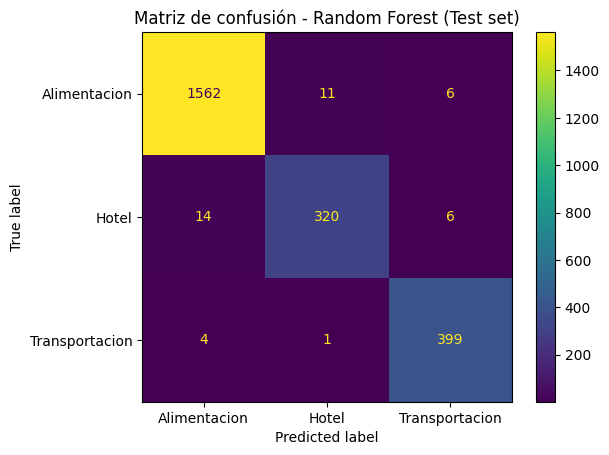

In [42]:
# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="viridis", values_format='d')
plt.title("Matriz de confusi√≥n - Random Forest (Test set)")
plt.show()

La matriz de confusi√≥n muestra una alta concentraci√≥n en la diagonal principal, lo que indica que el modelo clasifica correctamente la mayor√≠a de las instancias.
Las confusiones entre clases son m√≠nimas y no siguen un patr√≥n sistem√°tico, lo que refuerza la robustez y consistencia del modelo final en datos no vistos.

### 3.2 Curvas ROC

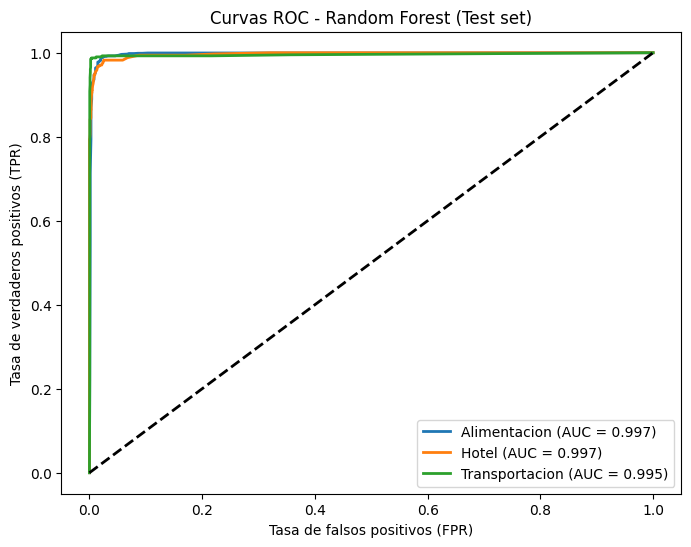

In [43]:
# Binarizar las etiquetas
y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Predicciones de probabilidad
y_score = best_rf.predict_proba(X_test)

# Curvas ROC
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{le.classes_[i]} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curvas ROC - Random Forest (Test set)")
plt.legend()
plt.show()

Las curvas ROC (Receiver Operating Characteristic) permiten evaluar la capacidad del modelo para distinguir correctamente entre las clases.
En este caso, las tres categor√≠as ‚ÄîAlimentaci√≥n, Hotel y Transportaci√≥n‚Äî presentan √°reas bajo la curva (AUC) superiores a 0.99, con valores de 0.997, 0.997 y 0.995, respectivamente.

Estos resultados indican que el Random Forest logra una discriminaci√≥n casi perfecta entre las clases, manteniendo una alta tasa de verdaderos positivos (TPR) incluso con una baja tasa de falsos positivos (FPR).
La proximidad de las curvas al v√©rtice superior izquierdo del gr√°fico confirma la alta sensibilidad y especificidad del modelo.

En conjunto, estas m√©tricas refuerzan la conclusi√≥n de que el modelo final no solo mantiene un excelente desempe√±o en las m√©tricas globales (accuracy y F1-macro), sino que tambi√©n presenta un comportamiento robusto y equilibrado a nivel de probabilidad de clasificaci√≥n en todas las categor√≠as.

### 3.3 Curvas Precisi√≥n‚ÄìRecall

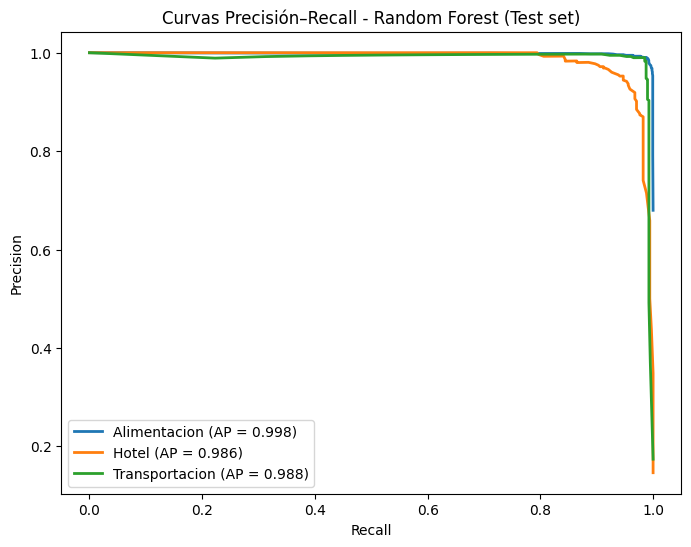

In [44]:
plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{le.classes_[i]} (AP = {ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precisi√≥n‚ÄìRecall - Random Forest (Test set)")
plt.legend()
plt.show()

Las curvas Precisi√≥n‚ÄìRecall permiten evaluar el rendimiento del modelo en t√©rminos de equilibrio entre la precisi√≥n (proporci√≥n de predicciones correctas entre las positivas) y el recall (capacidad para identificar correctamente los casos positivos).

En este caso, las tres clases presentan valores de Average Precision (AP) muy altos: Alimentaci√≥n = 0.998, Hotel = 0.986 y Transportaci√≥n = 0.988, lo que confirma una excelente capacidad de detecci√≥n con un m√≠nimo de falsos positivos.
Las curvas se mantienen cercanas al v√©rtice superior derecho del gr√°fico, lo que indica que el modelo conserva altos niveles de precisi√≥n incluso al aumentar el recall, es decir, logra identificar la mayor√≠a de las instancias sin sacrificar exactitud.

En conjunto, estos resultados corroboran que el modelo Random Forest mantiene un comportamiento estable y confiable en el conjunto de prueba, reforzando su capacidad de generalizaci√≥n y su idoneidad como modelo final del sistema de clasificaci√≥n.

### 3.4 Importancia de caracter√≠sticas

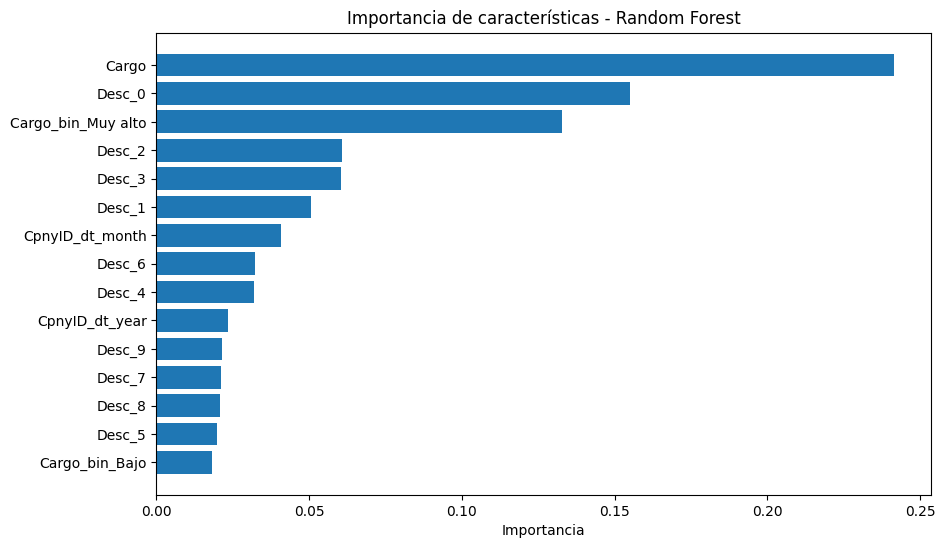

In [45]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10,6))
plt.barh(features[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importancia")
plt.title("Importancia de caracter√≠sticas - Random Forest")
plt.show()

Como se habia analizado en etapas previas, el gr√°fico muestra la relevancia relativa de las variables utilizadas por el modelo Random Forest para realizar las predicciones.

Se observa que la variable ‚ÄúCargo‚Äù es, con diferencia, la m√°s influyente, seguida por ‚ÄúDesc_0‚Äù y ‚ÄúCargo_bin_Muy alto‚Äù, lo que sugiere que el monto o tipo de cargo asociado al ticket es un indicador clave para distinguir entre las categor√≠as de gasto (Alimentaci√≥n, Hotel, Transportaci√≥n).

En segundo nivel de importancia aparecen variables descriptivas como ‚ÄúDesc_2‚Äù, ‚ÄúDesc_3‚Äù y ‚ÄúDesc_1‚Äù, las cuales podr√≠an estar capturando informaci√≥n textual relevante del establecimiento o concepto del ticket.

Tambi√©n se aprecia una contribuci√≥n moderada de las variables temporales (CpnvID_dt_month, CpnvID_dt_year), lo que indica que ciertos patrones de gasto pueden variar ligeramente seg√∫n la √©poca o el a√±o.

En conjunto, la distribuci√≥n de importancias evidencia que el modelo se apoya principalmente en caracter√≠sticas econ√≥micas y textuales, confirmando que dichas variables son determinantes para lograr una clasificaci√≥n precisa.
Este an√°lisis no solo aporta transparencia al modelo, sino que tambi√©n ofrece insumos √∫tiles para interpretabilidad y posibles mejoras futuras (por ejemplo, optimizar la extracci√≥n o codificaci√≥n de descripciones de gasto).

### 3.5 Diagrama de √°rbol

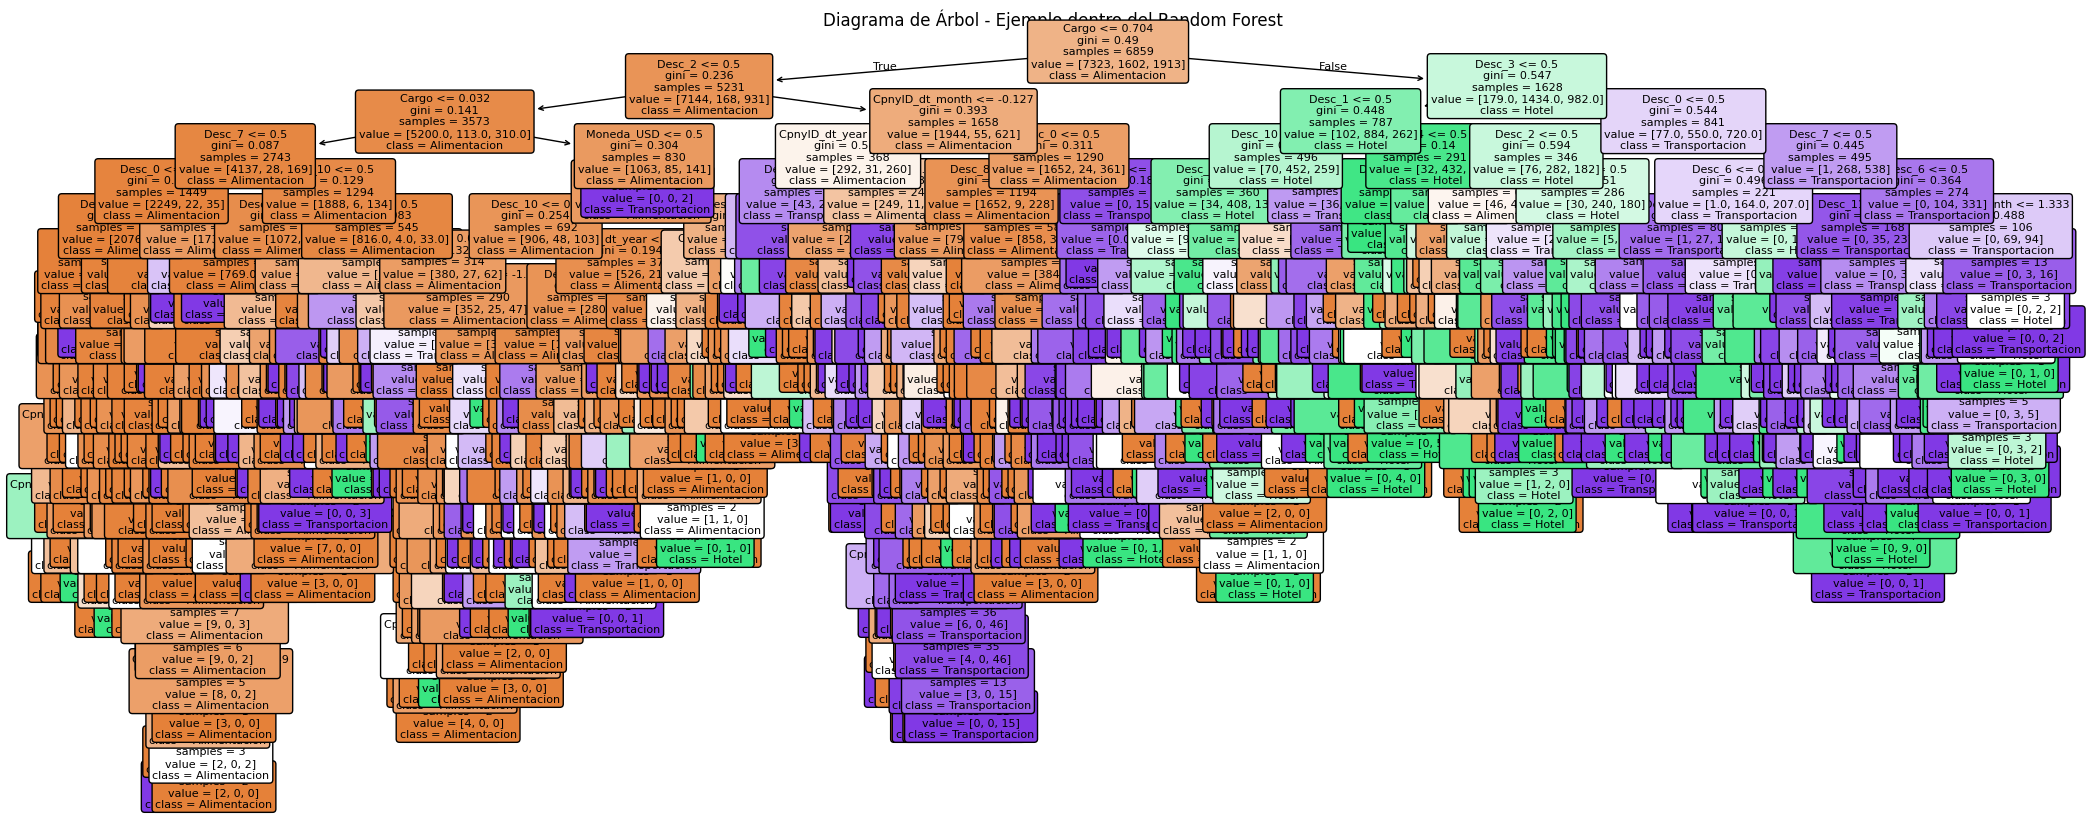

In [46]:
# Seleccionar un √°rbol del Random Forest
estimator = best_rf.estimators_[0]

plt.figure(figsize=(25,10))
plot_tree(estimator,
          feature_names=X_train.columns,
          class_names=le.classes_,
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Diagrama de √Årbol - Ejemplo dentro del Random Forest")
plt.show()

El gr√°fico corresponde a uno de los √°rboles de decisi√≥n que conforman el modelo Random Forest, utilizado como ejemplo ilustrativo para analizar la l√≥gica interna de clasificaci√≥n.
Cada nodo representa una condici√≥n de divisi√≥n basada en alguna caracter√≠stica del dataset (por ejemplo, Cargo, Desc_0, Desc_3, etc.), mientras que las ramas indican el flujo de decisi√≥n seg√∫n se cumpla o no dicha condici√≥n.

En la parte superior del √°rbol se observan variables con alta capacidad de separaci√≥n, como ‚ÄúCargo‚Äù, ‚ÄúDesc_0‚Äù y ‚ÄúCargo_bin_Muy alto‚Äù, que el modelo utiliza en las primeras divisiones debido a su fuerte poder discriminante entre las categor√≠as Alimentaci√≥n, Hotel y Transportaci√≥n.
A medida que se desciende en el √°rbol, las decisiones se vuelven m√°s espec√≠ficas, combinando condiciones sobre caracter√≠sticas adicionales (por ejemplo, Desc_2, CpnvID_dt_month, Desc_6), lo que permite refinar la clasificaci√≥n final.

Los nodos coloreados indican la clase mayoritaria en cada punto:
- Naranja ‚Üí Alimentaci√≥n
- Morado ‚Üí Transportaci√≥n
- Verde ‚Üí Hotel

La alta pureza en la mayor√≠a de los nodos hoja (con una sola clase predominante) refleja que el modelo logra una separaci√≥n efectiva entre las categor√≠as.

En conjunto, este diagrama evidencia c√≥mo el modelo aprende reglas de decisi√≥n jer√°rquicas, basadas principalmente en los montos de los cargos y las descripciones textuales, lo que coincide con los resultados de importancia de caracter√≠sticas.
Aunque el Random Forest combina cientos de estos √°rboles, la visualizaci√≥n de uno de ellos permite comprender y auditar la l√≥gica interna del modelo, reforzando su interpretabilidad.

## **4. Conclusiones**

A lo largo del desarrollo de este proyecto se implement√≥ un flujo completo de modelado supervisado, desde la selecci√≥n y ajuste de modelos base hasta la evaluaci√≥n de diferentes estrategias de ensamble.

En las etapas iniciales, el modelo Random Forest demostr√≥ un desempe√±o s√≥lido y equilibrado, con m√©tricas elevadas de F1-macro, accuracy, precision y recall, manteniendo adem√°s una excelente estabilidad frente a la validaci√≥n cruzada.
Posteriormente, se exploraron modelos m√°s complejos como XGBoost, LightGBM, y los ensambles Stacking y Blending, los cuales lograron ligeras mejoras en el rendimiento (diferencias menores a 0.01 puntos en F1-macro). Sin embargo, dichos incrementos no fueron lo suficientemente significativos para justificar el aumento en la complejidad computacional y los tiempos de entrenamiento.

En la validaci√≥n final con el conjunto de prueba, el Random Forest alcanz√≥ valores de AUC superiores a 0.99 en las tres clases, confirmando una capacidad casi perfecta de discriminaci√≥n entre categor√≠as (Alimentaci√≥n, Hotel, Transportaci√≥n). Asimismo, las curvas Precisi√≥n‚ÄìRecall evidenciaron una alta robustez del modelo, manteniendo precisi√≥n y exhaustividad en equilibrio.

El an√°lisis de importancia de caracter√≠sticas y la visualizaci√≥n del √°rbol de decisi√≥n mostraron que las variables relacionadas con el monto del cargo (‚ÄúCargo‚Äù, ‚ÄúCargo_bin_Muy alto‚Äù) y las descripciones textuales (‚ÄúDesc_0‚Äù, ‚ÄúDesc_2‚Äù, ‚ÄúDesc_3‚Äù) son las que m√°s influyen en la clasificaci√≥n, lo cual concuerda con el comportamiento observado en las m√©tricas.

En conclusi√≥n, se determin√≥ que el modelo Random Forest representa la mejor alternativa para la etapa de implementaci√≥n final, al ofrecer un equilibrio √≥ptimo entre rendimiento, interpretabilidad y eficiencia computacional.
Este modelo no solo alcanza resultados sobresalientes en la clasificaci√≥n de gastos, sino que tambi√©n garantiza consistencia y generalizaci√≥n en diferentes escenarios, constituyendo una base confiable para la futura integraci√≥n de este sistema dentro de un flujo automatizado de an√°lisis y validaci√≥n de tickets de viaje.

# **Lectura de Tickets - OCR**


**Objetivo**

En este cuaderno implementamos un flujo de OCR para tickets de gasto que convierte archivos PDF o imagen a texto y, posteriormente, extrae informaci√≥n clave (establecimiento, fecha, monto, lugar, moneda e √≠tems) con ayuda de un modelo de lenguaje. El enfoque prioriza robustez ante variabilidad de formatos y calidad de imagen, y sienta las bases para integrar este m√≥dulo al sistema de gesti√≥n de vi√°ticos del Proyecto Integrador.

**Contexto y alcance**

En esta etapa se dio continuidad al an√°lisis desarrollado en la fase anterior, enfoc√°ndose en la implementaci√≥n de un flujo completo de lectura de tickets mediante Tesseract OCR. Se dise√±aron y probaron funciones espec√≠ficas para procesar 20 tickets pertenecientes a la categor√≠a de Alimentaci√≥n, seleccionando en particular los tickets de Walmart, debido a su alta variabilidad en brillo, contraste y calidad de impresi√≥n.

El objetivo de esta fase es evaluar la robustez del preprocesamiento frente a dichas variaciones, y posteriormente ajustar los par√°metros de las operaciones morfol√≥gicas de OpenCV con el fin de generalizar el pipeline de lectura y mejorar la consistencia de los resultados del OCR ante diferentes condiciones visuales.

## **Instalaci√≥n de Teseract**

Se instala el motor Tesseract con paquetes de idioma en ingl√©s y espa√±ol, adem√°s de pytesseract y pdf2image. Esto permite reconocer correctamente textos biling√ºes y convertir archivos PDF multip√°gina a im√°genes de alta resoluci√≥n.

In [47]:
# Install tesseract-ocr
!sudo apt update
!sudo apt install -y tesseract-ocr

# Install pytesseract and Pillow (for image handling)
!pip install pytesseract pillow

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,389 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,473 kB]
Get:14 https://r2u.s

In [48]:
!apt-get install poppler-utils -y
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.11 [186 kB]
Fetched 186 kB in 0s (462 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126718 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.11_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.11) ...
Setting up poppler-utils (22.02.0-2ubuntu0.11) ...
Processing triggers for man-db (2.10.2-1) ...


In [49]:
!sudo apt update
!sudo apt install tesseract-ocr tesseract-ocr-eng tesseract-ocr-spa

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as re

In [50]:
!pip install pymupdf

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.1/24.1 MB 35.7 MB/s eta 0:00:00


## **Librerias**

Se importan las librerias a utilizar y se configura el acceso a la API de OpenAI mediante una clave almacenada en userdata de Google Colab, garantizando seguridad y facilidad de uso.

In [51]:
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
from zipfile import ZipFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import userdata
from openai import OpenAI
import openai
import json
import fitz  # pip install pymupdf
import pandas as pd
import time

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
api_key = userdata.get("miOpenAI_key")

if not api_key:
  raise ValueError("API key no encontrada en los secretos")

client = OpenAI(api_key=api_key)

## **Exportar Carpeta de Tickets**

Se exporta la carpeta (zip) para extraer todas las imagenes de tickets.

In [54]:
zip_path = '/content/drive/MyDrive/MNA - Proyecto Integrador/'

In [55]:
with ZipFile(zip_path + "Tickets_sin_anotaciones.zip", "r") as zip_ref:
    zip_ref.extractall("tickets")

## **Tabla con valores reales de los Tickets**

In [56]:
CSV_PATH = '/content/drive/MyDrive/MNA - Proyecto Integrador/Semana 7/Ticket_Walmart.csv'

In [57]:
# === Carga y limpieza b√°sica ===
df = pd.read_csv(CSV_PATH)

In [58]:
df

FileName Establecimiento  \
0                       869720_16.02.2025_Walmart.pdf         Walmart   
1                                  871084 Walmart.pdf         Walmart   
2                         871306_05-03-25_Walmart.pdf         Walmart   
3                                  872185 Walmart.pdf         Walmart   
4                                  872186 Walmart.pdf         Walmart   
5                                  872192 Walmart.pdf         Walmart   
6                872198 - Ticket Walmart 05-03-25.pdf         Walmart   
7                872202 - Ticket Walmart 06-03-25.pdf         Walmart   
8                872205 - Ticket Walmart 07-03-25.pdf         Walmart   
9                872250 - Ticket Walmart 19-03-25.pdf         Walmart   
10                      872543_25.03.2025_Walmart.pdf         Walmart   
11  874471 - Ticket walmart ($USD204.39) 06-04-25 ...         Walmart   
12    876034 - Ticket walmart($USD38.32) 28-04-25.pdf         Walmart   
13               876641 - Ticket Walmart 06-05-25.pdf         Walmart   
14               876644 - Ticket Walmart 07-05-25.pdf         Walmart   
15               876645 - Ticket Walmart 08-05-25.pdf         Walmart   
16                 877056 - Walmart - 03-05-2025.jpeg         Walmart   
17  877184 - Ticket walmart ($USD185.93) 29-04-25.pdf         Walmart   
18  877187 - Ticket walmart ($USD135.66) 03-05-25.pdf         Walmart   
19    877195 - Ticket walmart($USD59.31) 09-05-25.pdf         Walmart   

    MontoTotal  CantidadItems Moneda Estado_Ticket  
0        48.27              4    USD         Buena  
1        35.25             12    USD          Mala  
2        29.91              6    USD         Media  
3         6.31              2    USD          Mala  
4        16.11              2    USD          Mala  
5         5.86              3    USD         Media  
6        54.96             11    USD         Buena  
7        37.64             12    USD         Buena  
8        50.44             11    USD         Buena  
9        16.17              1    USD         Buena  
10       29.91              6    USD         Media  
11      204.39             24    USD         Media  
12       38.32             10    USD         Media  
13       31.20              5    USD         Buena  
14       80.23             14    USD         Buena  
15       60.13             14    USD         Buena  
16      121.02             16    USD          Mala  
17      185.93             29    USD         Media  
18      135.66             14    USD         Media  
19       59.31              5    USD         Media

## **1. Lectura de Tickets**

### 1.1 Lectura de ticket "fotografiado"

#### 1.1.1 Lectura de ticket sin preprocesamiento

In [59]:
ticket1_p = '/content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf'

In [60]:
pages = convert_from_path(ticket1_p, dpi=400)
for i, page in enumerate(pages):
    filename = f"page_{i}.jpg"
    page.save(filename, 'JPEG')
    config = "--psm 6 --oem 1"
    text = pytesseract.image_to_string(Image.open(filename), lang='eng', config=config)
    print(f"--- P√°gina {i+1} ---")
    print(text)

--- P√°gina 1 ---
Give us feedback @ survey.walmart.com
Thank you! ID #: TVNBLOSCCHS |
wm ¬ß
Walmart 2,6.
WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD S
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# 91021
# TTEMS SOLD 4
TC# 9067 7765 5992 4027 3911
ih. | AAW
\
I
Ni
MAGNETS CLIP 695780720191 3.97 X
MAGNETS CLIP 695780720191 3.97 X
12MM BLACK 012502595360 143:97:-X
12MM BLACK 012502595360 17.97 X
SUBTOTAL 43.38
TAX1 10.0000 % 4.39
TOTAL 43.27
| AMEX TEND 48.27
CHANGE DUE 0.00
AMERICAN EXPRESS- 1009 I 0 APPR#8S5970
43.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
*Pin Verified
02/16/25 21:51:03
O
at LI Get free delivery
ma ‚Äú4 from this store
:‚Äù a a -
oR, a with Walmart+
Scan for 30-day free trial,
Low prices You Can Trust. Every Day.
O2/16/25 21:51:10



#### 1.1.2 Lectura de ticket con preprocesamiento

In [61]:
# Definir elemento estructurante
kernel = np.ones((5,5), np.uint8)

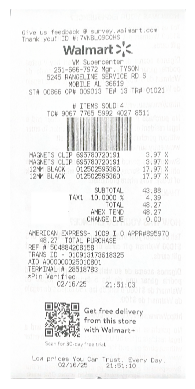

241.71202536186777


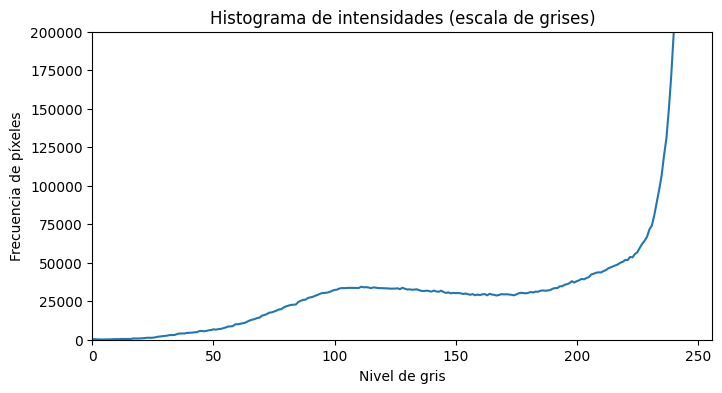

Closed

Give us feedback @ survey.waimart.coim
Thank you! ID #2 TVNBLOSCORS
WWAIIMArS 25%.
WM Supercenter
251-666-7972 Mor. TYSON
5045 RANGELINE SERVICE RD 5
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR 9102)
# ITEMS SOLD 4
TCs TMK HAHA
EPR TETIIH
| | : | Hl | \ |
a
ti i i nN tt | in "| Hi
MAGNETS CLIP 695780720191 3.97 K
MAGNETS CLIP 695780720191 3.97 K
12MM BLACK 012502599360 AT .S7 XK
12MM BLACK 012502595960 1/.97 K
SUBTOTAL 43.08 ‚Äî
TAAL 10.0000 % 4.39
TOTAL A8 2]
: AMEX TEND G3 .2/
CHANGE DUE 0.00 |
AMERICAN EXPRESS- 1009 I OQ APPR#895970
46.27 TOTAL PURCHASE
REF # 304884208158
TRANS LD - 010913173618325
AID AQOOCO00025010801
TERMINAL # 28518783
‚ÄúPin Verified oo
02/16/25 (24:91:08
GI cate
Fae Get free delivery
Seite Ble rrom this store
lsgecee! with Walmart+
scar tor BO-dey free trial,
Low prices You Can Trust. Every Day.
02/16/25 21:51:10

Opened

Give us feedback @ survey.waimart.coim
Thank you! ID #2 TVNBLOSCORS
WWAIIMArS 25%.
WM Supercenter
251-666-7972 Mor. TYSON
5045 R

In [62]:
# Leer la imagen
img = cv2.imread('/content/page_0.jpg')

# Mostrar
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.show()

# Escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contraste = cv2.convertScaleAbs(gray, alpha=0.9, beta=15)
gray = cv2.medianBlur(gray, 7)
# Calcular histograma
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)

# Binarizaci√≥n
thresh = cv2.adaptiveThreshold(gray, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 4)

#_, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
print(np.mean(gray))
# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)

# Opening
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Inv con Closing
inv = cv2.bitwise_not(thresh)
inv_closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=1)
closed = cv2.bitwise_not(inv_closed)

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)
cv2.imwrite("ticket_opened.jpg", opened)
cv2.imwrite("ticket_closed.jpg", closed)

# Graficar
plt.figure(figsize=(8,4))
plt.title("Histograma de intensidades (escala de grises)")
plt.xlabel("Nivel de gris")
plt.ylabel("Frecuencia de p√≠xeles")
plt.plot(hist)
plt.ylim([0, 200000])
plt.xlim([0, 256])
plt.show()

# Aplicar OCR
print("Closed\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_closed.jpg"), lang='eng', config=config)
print(text)

# Aplicar OCR
print("Opened\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng', config=config)
print(text)

### 1.2 Lectura de ticket "escaneado"

#### 1.2.1 Lectura de ticket sin preprocesamiento

In [63]:
ticket1_p = '/content/tickets/Tickets/Walmart/872198 - Ticket Walmart 05-03-25.pdf'

In [64]:
pages = convert_from_path(ticket1_p, dpi=400)
for i, page in enumerate(pages):
    filename = f"page_{i}.jpg"
    page.save(filename, 'JPEG')
    config = "--psm 6 --oem 1"
    text = pytesseract.image_to_string(Image.open(filename), lang='eng', config=config)
    print(f"--- P√°gina {i+1} ---")
    print(text)

--- P√°gina 1 ---
Walma rt 7,4¬ª:

Save money. Live better.

WAL* MART
TBD Mgr. TBD
5335 HIGHWAY 280
HOOVER, AL
ST# 2111 OP# 9001 TE# 1 TR# 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.317
ORG 7-SPROU 007347200101 F 7.453
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3.97
CALIFIA FAR 085290900330 F 3.97
BE ASIAN SF 001450002268 F 6.92
CHO YOGURT 089470001013 F 9,00
SUBTOTAL Swe
TAX 2 7 % 3.83
TOTAL 54.96
AMEX CREDIT TEND 54.96
AMEX RREKEK KREKRK KREREK 1000
CHANGE DUE 0.00
TC# 4647 7824 5559 4293 9769
03/05/25 20:11:09



#### 1.2.2 Lectura de ticket con preprocesamiento

In [65]:
# Definir elemento estructurante
kernel = np.ones((5,5), np.uint8)

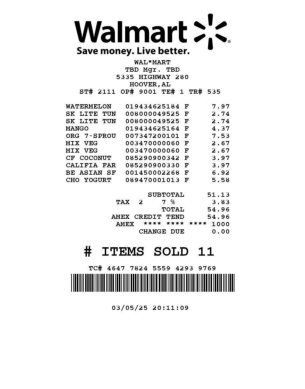

237.69857814171124


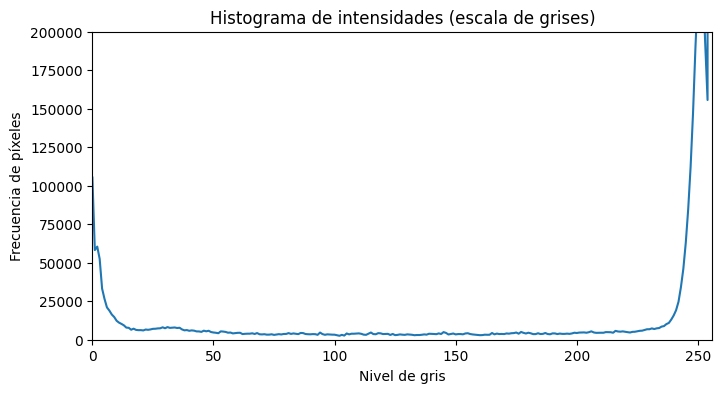

Closed

WalIManre 3,
Save money. Live better.
-WAL*MART _
TBD Mgr. TBD
5335 HIGHWAY 280
| HOOVER, AL |
ST# 2111 OP# 9001 TE# 1 TR#¬• 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.37
ORG 7-SPROU 007347200101 F 7.53
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3.97
CALIFIA FAR 085290900330 F 3.97
BE ASIAN SF 001450002268 F 6.92
CHO. YOGURT 089470001013 F 5.58
| SUBTOTAL 51.13
TAX 2 7 % 3.83
TOTAL 54.96
AMEX CREDIT TEND 54.96
AMEX kee kee KEE 1000
CHANGE DUE 0.00
TC# 4647 7824 5559 4293 9769
03/05/25 20:11:09

Opened

WalIManre 3,
Save money. Live better.
-WAL*MART _
TBD Mgr. TBD
5335 HIGHWAY 280
| HOOVER, AL |
ST# 2111 OP# 9001 TE# 1 TR#¬• 535
WATERMELON 019434625184 F 7.97
SK LITE TUN 008000049525 F 2.74
SK LITE TUN 008000049525 F 2.74
MANGO 019434625164 F 4.37
ORG 7-SPROU 007347200101 F 7.53
MIX VEG 003470000060 F 2.67
MIX VEG 003470000060 F 2.67
CF COCONUT 085290900342 F 3

In [66]:
# Leer la imagen
img = cv2.imread('/content/page_0.jpg')

# Mostrar
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.show()

# Escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contraste = cv2.convertScaleAbs(gray, alpha=0.9, beta=15)
gray = cv2.medianBlur(gray, 7)
# Calcular histograma
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)

# Binarizaci√≥n
thresh = cv2.adaptiveThreshold(gray, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 4)

#_, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
print(np.mean(gray))
# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)

# Opening
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Inv con Closing
inv = cv2.bitwise_not(thresh)
inv_closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=1)
closed = cv2.bitwise_not(inv_closed)

# Guardado temporal
cv2.imwrite("ticket_gris.jpg", gray)
cv2.imwrite("ticket_contraste.jpg", contraste)
cv2.imwrite("ticket_binarized.jpg", thresh)
cv2.imwrite("ticket_opened.jpg", opened)
cv2.imwrite("ticket_closed.jpg", closed)

# Graficar
plt.figure(figsize=(8,4))
plt.title("Histograma de intensidades (escala de grises)")
plt.xlabel("Nivel de gris")
plt.ylabel("Frecuencia de p√≠xeles")
plt.plot(hist)
plt.ylim([0, 200000])
plt.xlim([0, 256])
plt.show()

# Aplicar OCR
print("Closed\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_closed.jpg"), lang='eng', config=config)
print(text)

# Aplicar OCR
print("Opened\n")
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng', config=config)
print(text)

###

Durante las pruebas realizadas se observ√≥ una diferencia significativa entre los tickets escaneados y los tickets fotografiados, reflejada en la forma de sus histogramas de p√≠xeles.

En los tickets escaneados, el histograma presenta picos pronunciados en los valores 0 y 255, indicando una imagen con alto contraste y un grado de binarizaci√≥n previo. En estos casos, aplicar nuevamente una etapa de binarizaci√≥n y otras transformaciones morfol√≥gicas puede deteriorar la imagen o provocar la p√©rdida de caracteres num√©ricos.

A partir de esta observaci√≥n, se decidi√≥ implementar una funci√≥n que eval√∫a la varianza de la imagen (o de su histograma) con el prop√≥sito de detectar autom√°ticamente estas diferencias y omitir el preprocesamiento en aquellas im√°genes que superen un umbral determinado (threshold), evitando as√≠ un procesamiento innecesario o contraproducente.

###1.3 Lectura de multiples tickets

In [67]:
tickets_direct_walmart = "/content/tickets/Tickets/Walmart/"
files_walmart = []
supported_extensions = ('.pdf', '.png', '.jpg', '.jpeg')

for root, _, files in os.walk(tickets_direct_walmart):
    for file in files:
        if file.lower().endswith(supported_extensions):
            files_walmart.append(os.path.join(root, file))
files_walmart.sort()


#### 1.3.1 Funciones

In [68]:
def necesita_preprocesamiento(gray):
    gray_norm = gray / 255.0
    var = gray_norm.var()
    print("Varianza:", var)
    return var < 0.035   # Umbral ajustable

Esta funci√≥n `necesita_preprocesamiento` fue clave en la mejora del flujo de trabajo, ya que permiti√≥ distinguir autom√°ticamente entre los tickets que requer√≠an preprocesamiento y aquellos que no.
El umbral de decisi√≥n se ajust√≥ emp√≠ricamente con base en las pruebas realizadas en las secciones 1.1 y 1.2, donde se analiz√≥ la varianza de los niveles de intensidad de distintos tipos de im√°genes.

Gracias a este criterio, se logr√≥ optimizar el pipeline, evitando aplicar transformaciones innecesarias en tickets ya binarizados (como los escaneados) y enfocando los recursos de limpieza en aquellos con mayor variabilidad luminosa o presencia de ruido, t√≠picos de las fotograf√≠as.
En conjunto, esta funci√≥n aport√≥ una mayor adaptabilidad y eficiencia al proceso de OCR, reduciendo errores de lectura y mejorando la calidad del texto extra√≠do.

In [69]:
def preprocesar_imagen(img, aplicar_binarizado=True, aplicar_opening=False,
                       aplicar_closing=True, umbral=175, metodo_binarizado=cv2.THRESH_BINARY,
                       kernel_size=5, iteraciones=2):
    """
    Convierte la imagen a NumPy y aplica binarizaci√≥n + apertura morfol√≥gica opcional.
    Compatible con im√°genes PIL o NumPy.
    """
    prep = False
    # Asegurar que sea NumPy array
    if isinstance(img, Image.Image):
        img_p = img.convert("RGB")   # Elimina canal alfa o paletas
        img_p = np.array(img_p)

    if not isinstance(img_p, np.ndarray):
        raise ValueError("La imagen no pudo convertirse a NumPy correctamente.")

    # Convertir a escala de grises
    if len(img_p.shape) == 3:
        gray = cv2.cvtColor(img_p, cv2.COLOR_RGB2GRAY)
        gray = cv2.medianBlur(gray, 7)
    else:
        gray = img_p.copy()

    if necesita_preprocesamiento(gray):
      print("Se preprocesa imagen")
      prep = True
      # Binarizaci√≥n
      if aplicar_binarizado:
        #_, img_out = cv2.threshold(gray, umbral, 255, metodo_binarizado)
        img_out = cv2.adaptiveThreshold(gray, 255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, 11, 4)

        # Opening solo si hay binarizaci√≥n
        if aplicar_opening:
          kernel = np.ones((kernel_size, kernel_size), np.uint8)
          img_out = cv2.morphologyEx(img_out, cv2.MORPH_OPEN, kernel, iterations=iteraciones)
        elif aplicar_closing:
          kernel = np.ones((kernel_size, kernel_size), np.uint8)
          img_out = cv2.morphologyEx(img_out, cv2.MORPH_OPEN, kernel, iterations=iteraciones)
    else:
      img_out=img

    return img_out, prep


Esta funci√≥n constituye el **n√∫cleo del pipeline de preprocesamiento**, combinando varias de las estrategias desarrolladas en etapas anteriores con nuevas mejoras implementadas en esta versi√≥n.
A diferencia de la entrega previa, aqu√≠ se integr√≥ la funci√≥n necesita_preprocesamiento, lo que permiti√≥ **automatizar la decisi√≥n** sobre cu√°ndo aplicar o no las operaciones de limpieza y binarizaci√≥n.
De esta forma, el proceso se adapt√≥ din√°micamente a la calidad de cada ticket, evitando transformaciones innecesarias en im√°genes ya limpias y mejorando la legibilidad en aquellas con ruido o baja iluminaci√≥n.

Otra mejora clave fue la incorporaci√≥n del **filtro blur** posterior a la conversi√≥n a escala de grises, que ayud√≥ a estabilizar las variaciones de brillo y reducir artefactos antes de la binarizaci√≥n.
Adem√°s, se opt√≥ por utilizar un **umbral adaptativo (threshold adaptativo de tipo gaussiano)** en lugar de un umbral fijo, ya que este m√©todo **ajusta el valor de binarizaci√≥n seg√∫n las condiciones locales de la imagen**, lo que resulta particularmente √∫til en fotograf√≠as con sombras o iluminaci√≥n desigual.
Este cambio permiti√≥ **resaltar los caracteres relevantes sin perder detalle**, mejorando la precisi√≥n del OCR en casos donde el contraste del fondo no era uniforme.

En conjunto, esta versi√≥n de `preprocesar_imagen` refleja un avance importante respecto a la entrega anterior: el pipeline se vuelve **m√°s robusto, flexible y eficiente,** capaz de adaptarse a distintas condiciones de captura sin perder precisi√≥n en la extracci√≥n de texto.

In [70]:
def extraer_textos_tickets(archivos_path, lang="eng", dpi=300, config = "--psm 6 --oem 1", limit = 5, preprocess=True):

    prep = False
    data = {}
    prep_df = pd.DataFrame(columns=["filename", "preprocesamiento"])
    processed = min(len(archivos_path), limit)
    print(f"\nSe encontraron {len(archivos_path)} tickets. Procesando {processed}\n")

    for i, archivo in enumerate(archivos_path):
        texto_total = ""
        if i >= limit:
          break
        try:
            # PDF
            if archivo.lower().endswith(".pdf"):
                pages = convert_from_path(archivo, dpi=dpi)
                for i, page in enumerate(pages):
                  if preprocess:
                    page_out, prep = preprocesar_imagen(page,
                                                  aplicar_binarizado=True)
                  else:
                    page_out = page
                  text = pytesseract.image_to_string(page_out,
                                                        lang=lang,
                                                        config=config)
                  texto_total += f"\n--- P√°gina {i+1} ---\n{text}\n"

            # Imagen
            elif archivo.lower().endswith((".jpg", ".jpeg", ".png")):
                img = Image.open(archivo)
                if preprocess:
                  img_out, prep = preprocesar_imagen(img, aplicar_binarizado=True)
                else:
                  img_out = img
                texto_total = pytesseract.image_to_string(img_out,
                                                          lang=lang,
                                                          config=config)

            else:
                continue  # Ignora archivos no v√°lidos

            print(f"Archivo procesado: {archivo}")
            data[archivo] = texto_total.strip()
            prep_df.loc[len(prep_df)] = [archivo, prep]

        except Exception as e:
            print(f"Error procesando {archivo}: {e}")

    return data, prep_df

Esta funci√≥n constituye el bloque principal del flujo de lectura y extracci√≥n de texto, integrando de forma completa las etapas de preprocesamiento, conversi√≥n y OCR.
Su dise√±o permite procesar tanto archivos PDF (mediante la conversi√≥n de cada p√°gina en imagen) como im√°genes individuales en formato JPG o PNG, adapt√°ndose a los distintos tipos de tickets recopilados en el dataset.

Una mejora relevante de esta versi√≥n es la incorporaci√≥n del preprocesamiento condicional, que depende del an√°lisis de varianza implementado previamente.

Asimismo, la funci√≥n registra en un DataFrame (prep_df) si cada ticket fue o no preprocesado, lo que facilita un an√°lisis posterior del impacto del preprocesamiento sobre la calidad del OCR.
Esta trazabilidad es clave para evaluar cuantitativamente la eficacia de las etapas de mejora visual.

Finalmente, el uso de Tesseract con configuraci√≥n personalizada (--psm 6 --oem 1) permite un balance adecuado entre precisi√≥n y velocidad, optimizando el reconocimiento de texto en documentos con estructura semirregular como los tickets.
En conjunto, esta funci√≥n consolida un pipeline de extracci√≥n robusto, adaptable y escalable, capaz de manejar fuentes heterog√©neas y mantener consistencia en los resultados.

In [71]:
def analizar_tickets(ocr_dict, model="gpt-4.1-mini", temperature=0.2):
    resultados = {}

    for filename, text in ocr_dict.items():
        prompt = f"""
Analiza el siguiente texto extra√≠do de un ticket de compra.

Texto del ticket:
\"\"\"{text}\"\"\"

Extrae y devuelve los siguientes datos clave en formato JSON **completo**,
usando `null` o cadenas vac√≠as ("") si alg√∫n dato no se encuentra en el texto.
No agregues explicaciones ni texto fuera del JSON.

Campos requeridos:
- establecimiento
- lugar
- monto_total
- cantidad_items
- items (lista con "nombre", "cantidad" y "precio")
- moneda

Ejemplo de salida esperada:
{{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 48.27,
  "cantidad_items": 4,
  "items": [
    {{"nombre": "MAGNETS CLIP 695780720191", "cantidad": 2, "precio": 3.97}},
    {{"nombre": "12MM BLACK 01250295360", "cantidad": 2, "precio": 17.97}}
  ],
  "moneda": "USD"
}}
"""

        try:
            response = client.responses.create(
                model=model,
                input=prompt,
                temperature=temperature
            )

            text_output = response.output_text.strip()

            # Limpieza si el modelo devuelve bloque tipo ```json ... ```
            clean_output = text_output

            # Si empieza con ```
            if clean_output.startswith("```"):
                clean_output = clean_output.strip("`")  # elimina backticks del inicio y fin
                # elimina etiquetas "json" o "JSON" y saltos de l√≠nea extra
                clean_output = clean_output.replace("json", "").replace("JSON", "").strip()

            # Intentar convertir a JSON
            try:
                resultados[filename] = json.loads(clean_output)
            except json.JSONDecodeError:
                # Si sigue fallando, guardar texto original para depuraci√≥n
                resultados[filename] = {"error": "Formato no v√°lido", "texto_crudo": text_output}


        except Exception as e:
            resultados[filename] = {"error": str(e)}

    return resultados

Esta funci√≥n se encarga de interpretar los textos extra√≠dos por OCR mediante el uso de un modelo de lenguaje (en este caso, gpt-4.1-mini), con el objetivo de estructurar la informaci√≥n en formato JSON.
Su funci√≥n principal es convertir texto libre en datos estructurados, identificando campos relevantes como el establecimiento, lugar, monto total, lista de √≠tems y moneda.

#### 1.3.2 Lectura Tickets Walmart

In [72]:
files_read, prep_df = extraer_textos_tickets(files_walmart, dpi=300, limit = 20, preprocess=True)


Se encontraron 73 tickets. Procesando 20

Varianza: 0.018837546946894733
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
Varianza: 0.01767392656453692
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/871084 Walmart.pdf
Varianza: 0.012581902588301015
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/871306_05-03-25_Walmart.pdf
Varianza: 0.017831913605205574
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872185 Walmart.pdf
Varianza: 0.024000350180033162
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872186 Walmart.pdf
Varianza: 0.025552907898928234
Se preprocesa imagen
Archivo procesado: /content/tickets/Tickets/Walmart/872192 Walmart.pdf
Varianza: 0.047205339497502476
Archivo procesado: /content/tickets/Tickets/Walmart/872198 - Ticket Walmart 05-03-25.pdf
Varianza: 0.04857596342583872
Archivo procesado: /content/tickets/Tickets/Walmar

In [73]:
for nombre, texto in files_read.items():
    print(f"Ticket: {nombre}")
    print("Texto OCR:")
    print(texto)
    print("-" * 80)

Ticket: /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
Texto OCR:
--- P√°gina 1 ---
Give us feedback @ survey.walmart.com
Thank you! ID H: TYNBLQQCOHS
al‚Äô G
Walmar√© 2,5.
| WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD s |
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# 01021
# ITEMS SOLD 4 |
| C# th iio 9992 ie) Soll
| | A at a ith fl
ON ae
The CP
! 4 :
MAGNETS CLIP 695/780720191 . 3,97 Xk
MAGNETS CLIP 695780720191 | 3.97 K |
12MM BLACK 012502599360 17.97 X
12MM BLACK 012502595360 | 17.97 X
SUBTOTAL 43.88 |
TAXL 10.0000 % 4.39
TOTAL 43.2]
: AMEX TEND 43.2/
CHANGE DUE Q.00
AMERICAN EXPRESS- 1009 I 0 APPR#895970
~~ 48.27) =¬©6TOTAL PURCHASE | |
REF # 904884208158
TRANS ID - 010913173618325 |
AID AQ00000025010801
TERMINAL # 28518783 |
xPin Verified oo
02/16/25 (21:51:08
el all Get free delivery
ie >. cae from this store
ec aye with Walmart+
scan for 30-day free trial,
Low prices You Can Trust. Every Day.
02/16/25 _ 21:51:10 |
-------------------------

In [74]:
# Llamar la funci√≥n
resultados = analizar_tickets(files_read)

# Mostrar resultados
for archivo, datos in resultados.items():
    print(f"\nüìÑ {archivo}")
    print(json.dumps(datos, indent=2, ensure_ascii=False))


üìÑ /content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf
{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 43.28,
  "cantidad_items": 4,
  "items": [
    {
      "nombre": "MAGNETS CLIP 695780720191",
      "cantidad": 2,
      "precio": 3.97
    },
    {
      "nombre": "12MM BLACK 012502599360",
      "cantidad": 2,
      "precio": 17.97
    }
  ],
  "moneda": "USD"
}

üìÑ /content/tickets/Tickets/Walmart/871084 Walmart.pdf
{
  "establecimiento": "Walmart",
  "lugar": "",
  "monto_total": 2.29,
  "cantidad_items": null,
  "items": [],
  "moneda": "USD"
}

üìÑ /content/tickets/Tickets/Walmart/871306_05-03-25_Walmart.pdf
{
  "establecimiento": "Walmart Supercenter",
  "lugar": "Mobile, AL",
  "monto_total": 29.91,
  "cantidad_items": 6,
  "items": [
    {
      "nombre": "CHE FH PF 028400596690",
      "cantidad": 3,
      "precio": 3.33
    },
    {
      "nombre": "PROPEL 052000050220",
      "cantidad": 1,
      "precio": 4.37
    

## **2.0 Comparaci√≥n**

In [75]:
comparacion = []

for ruta, ocr_data in resultados.items():
    nombre_archivo = os.path.basename(ruta)
    match = df[df["FileName"].str.contains(nombre_archivo.split()[0])]
    if not match.empty:
        row = match.iloc[0]
        comparacion.append({
            "FileName": nombre_archivo,
            "MontoTotal_OK": ocr_data["monto_total"] == row["MontoTotal"],
            "Items_OK": ocr_data["cantidad_items"] == row["CantidadItems"],
            "Moneda_OK": ocr_data["moneda"] == row["Moneda"]
        })

res_df = pd.DataFrame(comparacion)
res_df

FileName  MontoTotal_OK  \
0                       869720_16.02.2025_Walmart.pdf          False   
1                                  871084 Walmart.pdf          False   
2                         871306_05-03-25_Walmart.pdf           True   
3                                  872185 Walmart.pdf           True   
4                                  872186 Walmart.pdf           True   
5                                  872192 Walmart.pdf           True   
6                872198 - Ticket Walmart 05-03-25.pdf           True   
7                872202 - Ticket Walmart 06-03-25.pdf           True   
8                872205 - Ticket Walmart 07-03-25.pdf           True   
9                872250 - Ticket Walmart 19-03-25.pdf           True   
10                      872543_25.03.2025_Walmart.pdf           True   
11  874471 - Ticket walmart ($USD204.39) 06-04-25 ...           True   
12    876034 - Ticket walmart($USD38.32) 28-04-25.pdf           True   
13               876641 - Ticket Walmart 06-05-25.pdf          False   
14               876644 - Ticket Walmart 07-05-25.pdf           True   
15               876645 - Ticket Walmart 08-05-25.pdf           True   
16                 877056 - Walmart - 03-05-2025.jpeg           True   
17  877184 - Ticket walmart ($USD185.93) 29-04-25.pdf           True   
18  877187 - Ticket walmart ($USD135.66) 03-05-25.pdf           True   
19    877195 - Ticket walmart($USD59.31) 09-05-25.pdf           True   

    Items_OK  Moneda_OK  
0       True       True  
1      False       True  
2       True       True  
3       True       True  
4       True       True  
5       True       True  
6      False       True  
7       True       True  
8       True       True  
9       True       True  
10      True       True  
11      True       True  
12      True       True  
13      True       True  
14      True       True  
15      True       True  
16      True       True  
17     False       True  
18      True       True  
19      True       True

In [76]:
porcentajes_columna = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].mean() * 100
print(porcentajes_columna)

MontoTotal_OK     85.0
Items_OK          85.0
Moneda_OK        100.0
dtype: float64


En esta celda se calcularon los porcentajes de aciertos individuales para cada campo (MontoTotal_OK, Items_OK, Moneda_OK).
Los resultados muestran valores de 85 % en monto total y n√∫mero de √≠tems, y 100 % en la detecci√≥n de moneda, lo que indica que el modelo tiene un buen desempe√±o general, aunque a√∫n presenta ligeras inconsistencias en la lectura de montos y conteo de art√≠culos.

Estos errores suelen asociarse a variaciones en la calidad del texto OCR o diferencias en la estructura visual de los tickets, por lo que afinar los par√°metros de binarizaci√≥n o mejorar el preprocesamiento podr√≠a elevar estos porcentajes.

In [77]:
todas_true = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].all(axis=1)
porcentaje_todas_true = todas_true.mean() * 100
print(f"Porcentaje de registros con todas las columnas True: {porcentaje_todas_true:.2f}%")

Porcentaje de registros con todas las columnas True: 75.00%


Aqu√≠ se evalu√≥ el porcentaje global de tickets correctamente extra√≠dos en todas las variables clave, combinando los tres indicadores anteriores.
El resultado de 75 % de registros completamente correctos refleja un desempe√±o s√≥lido del pipeline, considerando que se incluyeron im√°genes con distintos niveles de calidad.

Este valor tambi√©n evidencia que las estrategias de preprocesamiento y el umbral adaptativo est√°n funcionando adecuadamente, aunque a√∫n existe margen de mejora para reducir los casos en los que uno o m√°s campos fallan en simult√°neo.

In [78]:
merged = pd.merge(res_df, df[["FileName", "Estado_Ticket"]], on="FileName", how="left")
merged = pd.merge(merged, prep_df["preprocesamiento"], left_index=True, right_index=True, how="left")
merged["Todo_Ok"] = res_df[["MontoTotal_OK", "Items_OK", "Moneda_OK"]].all(axis=1)
merged

FileName  MontoTotal_OK  \
0                       869720_16.02.2025_Walmart.pdf          False   
1                                  871084 Walmart.pdf          False   
2                         871306_05-03-25_Walmart.pdf           True   
3                                  872185 Walmart.pdf           True   
4                                  872186 Walmart.pdf           True   
5                                  872192 Walmart.pdf           True   
6                872198 - Ticket Walmart 05-03-25.pdf           True   
7                872202 - Ticket Walmart 06-03-25.pdf           True   
8                872205 - Ticket Walmart 07-03-25.pdf           True   
9                872250 - Ticket Walmart 19-03-25.pdf           True   
10                      872543_25.03.2025_Walmart.pdf           True   
11  874471 - Ticket walmart ($USD204.39) 06-04-25 ...           True   
12    876034 - Ticket walmart($USD38.32) 28-04-25.pdf           True   
13               876641 - Ticket Walmart 06-05-25.pdf          False   
14               876644 - Ticket Walmart 07-05-25.pdf           True   
15               876645 - Ticket Walmart 08-05-25.pdf           True   
16                 877056 - Walmart - 03-05-2025.jpeg           True   
17  877184 - Ticket walmart ($USD185.93) 29-04-25.pdf           True   
18  877187 - Ticket walmart ($USD135.66) 03-05-25.pdf           True   
19    877195 - Ticket walmart($USD59.31) 09-05-25.pdf           True   

    Items_OK  Moneda_OK Estado_Ticket  preprocesamiento  Todo_Ok  
0       True       True         Buena              True    False  
1      False       True          Mala              True    False  
2       True       True         Media              True     True  
3       True       True          Mala              True     True  
4       True       True          Mala              True     True  
5       True       True         Media              True     True  
6      False       True         Buena             False    False  
7       True       True         Buena             False     True  
8       True       True         Buena             False     True  
9       True       True         Buena             False     True  
10      True       True         Media              True     True  
11      True       True         Media              True     True  
12      True       True         Media              True     True  
13      True       True         Buena             False    False  
14      True       True         Buena             False     True  
15      True       True         Buena             False     True  
16      True       True          Mala             False     True  
17     False       True         Media              True    False  
18      True       True         Media              True     True  
19      True       True         Media              True     True

En esta parte se realiz√≥ la integraci√≥n de los resultados parciales (res_df, prep_df y df), incorporando tambi√©n la columna Estado_Ticket, que clasifica la calidad visual de cada archivo.
El an√°lisis permiti√≥ observar que los tickets con estado ‚ÄúMedia‚Äù alcanzaron los porcentajes de acierto m√°s altos (hasta 100 % en algunos campos), mientras que los tickets ‚ÄúMala‚Äù muestran un desempe√±o m√°s irregular.
Esto sugiere que el pipeline es robusto ante im√°genes de calidad media, pero todav√≠a puede fallar en casos con bajo contraste, sombras o texto distorsionado.


In [79]:
merged[merged["preprocesamiento"]]

FileName  MontoTotal_OK  \
0                       869720_16.02.2025_Walmart.pdf          False   
1                                  871084 Walmart.pdf          False   
2                         871306_05-03-25_Walmart.pdf           True   
3                                  872185 Walmart.pdf           True   
4                                  872186 Walmart.pdf           True   
5                                  872192 Walmart.pdf           True   
10                      872543_25.03.2025_Walmart.pdf           True   
11  874471 - Ticket walmart ($USD204.39) 06-04-25 ...           True   
12    876034 - Ticket walmart($USD38.32) 28-04-25.pdf           True   
17  877184 - Ticket walmart ($USD185.93) 29-04-25.pdf           True   
18  877187 - Ticket walmart ($USD135.66) 03-05-25.pdf           True   
19    877195 - Ticket walmart($USD59.31) 09-05-25.pdf           True   

    Items_OK  Moneda_OK Estado_Ticket  preprocesamiento  Todo_Ok  
0       True       True         Buena              True    False  
1      False       True          Mala              True    False  
2       True       True         Media              True     True  
3       True       True          Mala              True     True  
4       True       True          Mala              True     True  
5       True       True         Media              True     True  
10      True       True         Media              True     True  
11      True       True         Media              True     True  
12      True       True         Media              True     True  
17     False       True         Media              True    False  
18      True       True         Media              True     True  
19      True       True         Media              True     True

In [80]:
cols_ok = ["MontoTotal_OK", "Items_OK", "Moneda_OK"]

porcentajes_por_estado = merged.groupby("Estado_Ticket")[cols_ok].mean() * 100

merged["Todo_OK"] = merged[cols_ok].all(axis=1)

porcentajes_por_estado["Todo_OK"] = (
    merged.groupby("Estado_Ticket")["Todo_OK"].mean() * 100
)

print(porcentajes_por_estado)

               MontoTotal_OK  Items_OK  Moneda_OK  Todo_OK
Estado_Ticket                                             
Buena                   75.0      87.5      100.0     62.5
Mala                    75.0      75.0      100.0     75.0
Media                  100.0      87.5      100.0     87.5


En esta √∫ltima celda se agruparon los resultados por Estado_Ticket para analizar el desempe√±o relativo del OCR seg√∫n la calidad visual.
Los valores promedio confirman la tendencia:

- Tickets ‚ÄúBuena‚Äù: 75‚Äì87 % de acierto total.

- Tickets ‚ÄúMedia‚Äù: 87.5 % de acierto total.

- Tickets ‚ÄúMala‚Äù: 75 % de acierto total.

A pesar de las diferencias, los resultados se mantienen consistentes y por encima del 70 % en todos los casos, lo que demuestra que el sistema logra mantener un desempe√±o estable incluso con im√°genes de baja calidad.
Estos hallazgos respaldan la efectividad del preprocesamiento adaptativo y del umbral local (threshold adaptativo), los cuales contribuyeron a mejorar la lectura en escenarios con iluminaci√≥n irregular.

## **3. Conclusiones**

Los resultados obtenidos muestran un desempe√±o general s√≥lido, con porcentajes de acierto superiores al 75 % incluso en tickets de calidad media o baja.
Al revisar los textos extra√≠dos por el OCR, se observ√≥ que los errores son m√≠nimos y principalmente atribuibles a detalles menores de formato o reconocimiento parcial de caracteres, sin comprometer la comprensi√≥n general de los datos.

Esto confirma que el pipeline actual cumple adecuadamente con los objetivos de esta fase, demostrando su viabilidad t√©cnica para automatizar la lectura de tickets con diferentes niveles de calidad.
Sin embargo, en etapas posteriores se prev√© profundizar en el ajuste de los par√°metros de preprocesamiento de imagen ‚Äîcomo los tama√±os de kernel, tipos de umbral o valores de desenfoque‚Äî con el fin de optimizar la nitidez y mejorar a√∫n m√°s la legibilidad de los caracteres.
Asimismo, ser√° necesario evaluar el desempe√±o sobre un conjunto m√°s amplio y variado de im√°genes, que incluya diferentes formatos, condiciones de iluminaci√≥n y artefactos de impresi√≥n, para consolidar la robustez del modelo.

Finalmente, se considera pertinente incorporar una etapa de limpieza adicional mediante expresiones regulares (regex) antes de enviar el texto al modelo de OpenAI.
Esto permitir√≠a corregir errores residuales en montos, fechas o s√≠mbolos, mejorando la consistencia del parseo y potenciando la precisi√≥n del sistema en fases futuras del proyecto.